# Impacto de la deforestación en el regimen de caudales de los rios en Colombia (TEAM 28)

## Multivariate time series forecasting

Sources :

https://towardsdatascience.com/vector-autoregressions-vector-error-correction-multivariate-model-a69daf6ab618

https://towardsdatascience.com/pairs-trading-with-cryptocurrencies-e79b4a00b015

### Libraries

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.vector_ar as var
import sklearn.metrics as skm

# from statsmodels.tsa.stattools import grangercausalitytests # Granger's Causality Test

# from statsmodels.graphics.tsaplots import plot_acf # Autocorrelation plot
# from statsmodels.graphics.tsaplots import plot_pacf # PartialAutocorrelation plot

# from sklearn.model_selection import train_test_split # Split data for machine learning

# from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller Test (ADF Test)/unit root test
# from statsmodels.tsa.stattools import coint  # Johansen Test for Cointegration (Just two data series)

# from coint_johansen import coint_johansen  # Johansen Test for Cointegration more two data series
# from scipy.stats import zscore # Calculates the z score of each value in the sample, relative to the sample mean and standard deviation.

# from sklearn.utils import check_array # Para calculo de MAPE

# from sklearn.ensemble import RandomForestRegressor
# from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num = None, figsize = (15, 12), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.rcParams.update({'font.size': 16, 'figure.figsize': (15, 10), 
                     'figure.max_open_warning': 200})

# machine learning: XGB
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor # wrapper

<Figure size 1200x960 with 0 Axes>

In [2]:
print(plt.rcParams.keys())

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

### Read Data

In [3]:
macrodata = pd.read_csv('../data/matrix/matrix_consol_v2.zip')

macrodata.head(10)

,date,year,month,mc,v_flow_mean,v_loss_cover,v_rainfall_total,v_temperature_mean
0,2000-01,2000,1,7,230.4,0.000000,334.0,NaN
1,2000-02,2000,2,7,272.4,0.000133,400.0,NaN
2,2000-03,2000,3,7,321.6,0.000265,319.0,NaN
3,2000-04,2000,4,7,310.8,0.000398,248.0,NaN
4,2000-05,2000,5,7,410.0,0.000531,302.0,NaN
5,2000-06,2000,6,7,295.9,0.000663,81.0,NaN
6,2000-07,2000,7,7,244.2,0.000796,96.0,NaN
7,2000-08,2000,8,7,255.0,0.000928,64.0,NaN
8,2000-09,2000,9,7,233.8,0.001061,262.0,NaN
9,2000-10,2000,10,7,216.0,0.001194,141.0,NaN


In [4]:
mcs = macrodata['mc'].unique()
mcs.sort()

print(mcs)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]


### Split data for machine learning algorithms

In [5]:
temp_df = macrodata.copy()

data_train = pd.DataFrame()
data_test = pd.DataFrame()

for i in mcs:
    #train, test = train_test_split(temp_df[temp_df['mc'] == i], test_size = 0.2)
    nobs = 24 # 10% de 240
    train, test = temp_df[temp_df['mc'] == i].iloc[0:-nobs], temp_df[temp_df['mc'] == i].iloc[-nobs:]
    data_train = pd.concat([data_train, train], axis = 0)
    data_test = pd.concat([data_test, test], axis = 0)

print('Total data')
print('----------')
print(macrodata.shape)
print(macrodata.dtypes)
print()
print('data_train')
print('----------')
print(data_train.shape)
print(data_train.dtypes)
print()
print('data_test')
print('---------')
print(data_test.shape)
print(data_test.dtypes)

temp_df.head(10)

Total data
----------
(11520, 8)
date                   object
year                    int64
month                   int64
mc                      int64
v_flow_mean           float64
v_loss_cover          float64
v_rainfall_total      float64
v_temperature_mean    float64
dtype: object

data_train
----------
(10368, 8)
date                   object
year                    int64
month                   int64
mc                      int64
v_flow_mean           float64
v_loss_cover          float64
v_rainfall_total      float64
v_temperature_mean    float64
dtype: object

data_test
---------
(1152, 8)
date                   object
year                    int64
month                   int64
mc                      int64
v_flow_mean           float64
v_loss_cover          float64
v_rainfall_total      float64
v_temperature_mean    float64
dtype: object


,date,year,month,mc,v_flow_mean,v_loss_cover,v_rainfall_total,v_temperature_mean
0,2000-01,2000,1,7,230.4,0.000000,334.0,NaN
1,2000-02,2000,2,7,272.4,0.000133,400.0,NaN
2,2000-03,2000,3,7,321.6,0.000265,319.0,NaN
3,2000-04,2000,4,7,310.8,0.000398,248.0,NaN
4,2000-05,2000,5,7,410.0,0.000531,302.0,NaN
5,2000-06,2000,6,7,295.9,0.000663,81.0,NaN
6,2000-07,2000,7,7,244.2,0.000796,96.0,NaN
7,2000-08,2000,8,7,255.0,0.000928,64.0,NaN
8,2000-09,2000,9,7,233.8,0.001061,262.0,NaN
9,2000-10,2000,10,7,216.0,0.001194,141.0,NaN


In [6]:
data_train.head(10)

,date,year,month,mc,v_flow_mean,v_loss_cover,v_rainfall_total,v_temperature_mean
7920,2000-01,2000,1,1,2.45,0.000000,299.12,18.300
7921,2000-02,2000,2,1,2.14,0.000552,333.86,18.200
7922,2000-03,2000,3,1,2.53,0.001105,264.73,18.500
7923,2000-04,2000,4,1,2.38,0.001657,170.73,18.700
7924,2000-05,2000,5,1,4.64,0.002210,65.17,18.400
7925,2000-06,2000,6,1,3.06,0.002762,72.36,18.875
7926,2000-07,2000,7,1,3.12,0.003314,42.85,18.800
7927,2000-08,2000,8,1,4.84,0.003867,52.01,19.600
7928,2000-09,2000,9,1,3.22,0.004419,20.73,18.650
7929,2000-10,2000,10,1,2.33,0.004972,92.40,18.300


In [7]:
data_test.head(10)

,date,year,month,mc,v_flow_mean,v_loss_cover,v_rainfall_total,v_temperature_mean
8136,2018-01,2018,1,1,1.60,0.072060,222.87,18.80
8137,2018-02,2018,2,1,1.57,0.072256,143.49,19.10
8138,2018-03,2018,3,1,2.10,0.072453,274.72,19.60
8139,2018-04,2018,4,1,2.99,0.072649,65.35,18.80
8140,2018-05,2018,5,1,3.40,0.072846,214.84,19.00
8141,2018-06,2018,6,1,4.61,0.073042,145.44,19.10
8142,2018-07,2018,7,1,4.19,0.073239,15.04,19.60
8143,2018-08,2018,8,1,3.46,0.073435,21.49,20.20
8144,2018-09,2018,9,1,2.31,0.073632,3.66,19.85
8145,2018-10,2018,10,1,2.48,0.073828,83.10,19.20


In [8]:
dates = pd.DataFrame(pd.date_range('2018-01-01','2019-12-31' , freq='1M') - 
             pd.offsets.MonthBegin(1))
dates.columns = ['date']

dates['year'] = pd.DatetimeIndex(dates['date']).year
dates['month'] = pd.DatetimeIndex(dates['date']).month

dates.head()

,date,year,month
0,2018-01-01,2018,1
1,2018-02-01,2018,2
2,2018-03-01,2018,3
3,2018-04-01,2018,4
4,2018-05-01,2018,5


## XGBoost

[XGBoost](https://github.com/dmlc/xgboost/blob/master/doc/model.md) is an implementation of Gradient Boosted Decision trees designed for speed and performance. Its more suitable name is a as [regularized Gradient Boosting](http://datascience.la/xgboost-workshop-and-meetup-talk-with-tianqi-chen/), as it uses a more regularized model formalization to control over-fitting.

Additional advantages of this algorythm are:
- Automated missing values handling: XGB uses a "learned" default direction for the missing values. "Learned" means learned in the tree construction process by choosing the best direction that optimizes the training loss.
- Interactive feature analysis (yet implemented only in R): plots the structure of decision trees with splits and leaves.
- Feature importance analysis: a sorted barplot of the most significant variables.

<div class = "alert alert-block alert-info"> As we already saw in the previos section our data is higly seasonal and not random (dependent). Therefore, before fitting any models we need to "smooth" target variable Sales. The typical preprocessing step is to log transform the data in question. Once we perform the forecasting we will unwind log transformations in reverse order. </div>

### Model Training

**Approach**

1. Split train data to train and test set to evaluate the model.
2. Set eta to a relatively high value (e.g. 0.05 ~ 0.1), num_round to 300 ~ 500
3. Use grid search to find the best combination of additional parameters.
4. Lower eta until we reach the optimum.
5. Use the validation set as watchlist to retrain the model with the best parameters.

In [ ]:
# split into training and evaluation sets

# v_flow_mean
# v_loss_cover
# v_rainfall_total
# v_temperature_mean
# v_flow_mean_log
# v_loss_cover_log
# v_rainfall_total_log
# v_flow_mean_log_diff
# v_loss_cover_log_diff
# v_rainfall_total_log_diff

# predictors = [x for x in train_store.columns if x not in ['Customers', 'Sales', 'SalePerCustomer']]
# y = np.log(train_store.Sales) # log transformation of Sales
# X = train_store

# # split the data into train/test set
# X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                     test_size = 0.1, # 30% for the evaluation set
#                                                     random_state = 42)

In [9]:
data_train['v_loss_cover_porc'] = data_train['v_loss_cover'] * 1000

data_train.head()

,date,year,month,mc,v_flow_mean,v_loss_cover,v_rainfall_total,v_temperature_mean,v_loss_cover_porc
7920,2000-01,2000,1,1,2.45,0.000000,299.12,18.3,0.000000
7921,2000-02,2000,2,1,2.14,0.000552,333.86,18.2,0.552391
7922,2000-03,2000,3,1,2.53,0.001105,264.73,18.5,1.104781
7923,2000-04,2000,4,1,2.38,0.001657,170.73,18.7,1.657172
7924,2000-05,2000,5,1,4.64,0.002210,65.17,18.4,2.209563


In [10]:
data_test['v_loss_cover_porc'] = data_test['v_loss_cover'] * 1000

data_test.head()

,date,year,month,mc,v_flow_mean,v_loss_cover,v_rainfall_total,v_temperature_mean,v_loss_cover_porc
8136,2018-01,2018,1,1,1.60,0.072060,222.87,18.8,72.060005
8137,2018-02,2018,2,1,1.57,0.072256,143.49,19.1,72.256450
8138,2018-03,2018,3,1,2.10,0.072453,274.72,19.6,72.452895
8139,2018-04,2018,4,1,2.99,0.072649,65.35,18.8,72.649340
8140,2018-05,2018,5,1,3.40,0.072846,214.84,19.0,72.845785


In [11]:
predictors = ['v_loss_cover_porc', 'v_rainfall_total']
# predictors = ['v_loss_cover', 'v_rainfall_total']

In [12]:
# evaluation metric: rmspe
# Root Mean Square Percentage Error
# code chunk shared at Kaggle

def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat / y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y, yhat)

**Tuning Parameters** 

- eta: Step size used in updating weights. Lower value means slower training but better convergence.
- num_round: Total number of iterations.
- subsample: The ratio of training data used in each iteration; combat overfitting. Should be configured in the range of 30% to 80% of the training dataset, and compared to a value of 100% for no sampling.
- colsample_bytree: The ratio of features used in each iteration, default 1.
- max_depth: The maximum depth of each tree. If we do not limit max depth, gradient boosting would eventually overfit.
- early_stopping_rounds: If there's no increase in validation score for a given number of iterations, the algorithm will stop early, also combats overfitting.

In [13]:
# base parameters
# params = {
#     'booster': 'gbtree', 
#     'objective': 'reg:squarederror', # regression task
#     'subsample': 0.8, # 80% of data to grow trees and prevent overfitting
#     'colsample_bytree': 0.85, # % of features used
#     'eta': 0.08, 
#     'max_depth': 10, 
#     'seed': 42} # for reproducible results

params = {
    'booster': 'gbtree', 
    'objective': 'reg:squarederror', # regression task
    'subsample': 0.8, # 80% of data to grow trees and prevent overfitting
    'colsample_bytree': 1, # % of features used
    'eta': 0.08, 
    'max_depth': 10, 
    'seed': 42} # for reproducible results


MC = 1

First validation yelds RMSPE: 0.381242
[1.1664875  1.046189   0.929405   0.90966094 1.1847215  1.1520784
 0.85858786 0.84825754 0.84450805 0.85440004 0.96556133 0.9662341
 1.0793303  0.93873143 0.9537342  1.0983624  1.0067275  0.99860215
 1.2598398  0.86272156 0.6990489  1.058745   0.9576937  0.9662341 ]
        date  year  month  v_flow_mean_mean  v_flow_mean  v_loss_cover  \
0 2018-01-01  2018      1          3.210695         1.60      0.072060   
1 2018-02-01  2018      2          2.846781         1.57      0.072256   
2 2018-03-01  2018      3          2.533002         2.10      0.072453   
3 2018-04-01  2018      4          2.483480         2.99      0.072649   
4 2018-05-01  2018      5          3.269776         3.40      0.072846   

   v_rainfall_total  mc  
0            222.87   1  
1            143.49   1  
2            274.72   1  
3             65.35   1  
4            214.84   1  
   mc      Bias       MAE       MSE      RMSE
0   1  0.194461  0.720702  0.865381  0

        date  year  month  v_flow_mean_mean  v_flow_mean  v_loss_cover  \
0 2018-01-01  2018      1         46.194130    38.656250      0.022157   
1 2018-02-01  2018      2         36.804218    32.871875      0.022197   
2 2018-03-01  2018      3         38.131065    29.732500      0.022237   
3 2018-04-01  2018      4         45.451988    61.090625      0.022276   
4 2018-05-01  2018      5         43.343857    74.456250      0.022316   

   v_rainfall_total  mc  
0             501.6   8  
1             170.0   8  
2             265.0   8  
3             321.4   8  
4             298.8   8  
   mc      Bias       MAE         MSE       RMSE
0   8  5.161439  12.91369  293.874052  17.142755


MC = 9

First validation yelds RMSPE: 0.553696
[0.29375947 0.24762681 1.0783055  3.2385252  3.209501   3.6024568
 3.2785923  3.261472   2.669506   2.327664   0.4569241  0.22801378
 0.5919521  0.32205218 0.3040761  1.0614867  3.1498628  3.6057396
 3.3981833  3.2136471  1.9891846  1.0614867  1.114649

        date  year  month  v_flow_mean_mean  v_flow_mean  v_loss_cover  \
0 2018-01-01  2018      1        537.387207   356.974250      0.093201   
1 2018-02-01  2018      2        302.207092   374.054734      0.093527   
2 2018-03-01  2018      3        532.685242   390.298594      0.093852   
3 2018-04-01  2018      4        363.220612   633.882484      0.094177   
4 2018-05-01  2018      5        632.378784   770.172604      0.094503   

   v_rainfall_total  mc  
0        105.387791  16  
1         18.488814  16  
2        132.335207  16  
3        255.519824  16  
4        306.154722  16  
   mc       Bias         MAE          MSE        RMSE
0  16 -50.471476  151.040893  29368.61743  171.372744


MC = 17

First validation yelds RMSPE: 0.315563
[1.9752825 2.0284445 1.9678636 2.4209552 2.4377096 2.2925935 2.1629157
 2.0406823 2.05265   1.9608282 1.9109263 1.9191115 1.9212024 1.9661404
 1.9490963 2.1605554 2.4873505 2.5130162 2.4283724 1.8908916 2.0980432
 2.0453176 2.1829715 2.04442

        date  year  month  v_flow_mean_mean  v_flow_mean  v_loss_cover  \
0 2018-01-01  2018      1         15.728148    18.221387      0.148725   
1 2018-02-01  2018      2         10.544327    13.416203      0.149879   
2 2018-03-01  2018      3         18.826103    12.836600      0.151032   
3 2018-04-01  2018      4         17.973555    30.089406      0.152186   
4 2018-05-01  2018      5         19.739395    23.008488      0.153340   

   v_rainfall_total  mc  
0         87.615608  24  
1         58.992578  24  
2        228.345545  24  
3        213.565394  24  
4        120.847023  24  
   mc      Bias       MAE        MSE      RMSE
0  24  1.432545  5.609573  82.583821  9.087564


MC = 25

First validation yelds RMSPE: 0.321899
[1.9847622 1.6913596 1.9226491 2.1469173 2.324719  2.302907  1.98031
 1.6913596 1.743036  2.4361887 2.1827147 2.0883565 1.6913596 1.6913596
 1.6913596 1.9860796 2.2107477 2.1529584 1.6999328 1.6917245 1.6913596
 2.1130753 2.3140812 2.4361887]
        date

        date  year  month  v_flow_mean_mean  v_flow_mean  v_loss_cover  \
0 2018-01-01  2018      1         44.003960        36.39      0.022922   
1 2018-02-01  2018      2         52.225517        36.50      0.022957   
2 2018-03-01  2018      3         38.815067        38.00      0.022992   
3 2018-04-01  2018      4         36.029129        39.17      0.023027   
4 2018-05-01  2018      5         36.029129        37.59      0.023062   

   v_rainfall_total  mc  
0            164.02  32  
1            183.23  32  
2            145.11  32  
3             91.33  32  
4             89.46  32  
   mc      Bias       MAE        MSE       RMSE
0  32 -0.170141  8.909481  115.31363  10.738418


MC = 33

First validation yelds RMSPE: 0.581752
[1.8961977 2.001329  1.6431189 1.769423  1.9519005 1.9679769 1.2253286
 1.2183783 1.2435764 1.3817488 2.0408247 1.6552367 1.2183783 1.8898865
 1.447659  1.9787781 1.7580688 1.6876526 1.2253286 1.3520318 1.200114
 1.5370175 2.009214  1.713219 ]


<ipython-input-12-5beb244f18bf>:6: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(np.mean((yhat / y-1) ** 2))


        date  year  month  v_flow_mean_mean  v_flow_mean  v_loss_cover  \
0 2018-01-01  2018      1          6.660521         6.41      0.025342   
1 2018-02-01  2018      2          7.398882         5.42      0.025392   
2 2018-03-01  2018      3          5.171273         4.92      0.025442   
3 2018-04-01  2018      4          5.867467         4.81      0.025493   
4 2018-05-01  2018      5          7.042058         3.47      0.025543   

   v_rainfall_total  mc  
0            355.54  33  
1            296.24  33  
2            395.62  33  
3            195.47  33  
4            207.81  33  
   mc      Bias       MAE       MSE      RMSE
0  33 -1.015243  1.789747  4.191695  2.047363


MC = 34

First validation yelds RMSPE: 0.270956
[5.0060625 5.330111  5.4462585 5.783515  6.2099586 6.2099586 5.795274
 5.784973  5.131486  5.0957804 5.1177874 5.1821885 5.2124405 5.1736064
 5.620641  5.6465607 6.105436  6.105436  6.105436  5.6479897 5.1898355
 5.4888415 5.4425197 5.2041564]
        date 

        date  year  month  v_flow_mean_mean  v_flow_mean  v_loss_cover  \
0 2018-01-01  2018      1       1153.710815   1072.65625      0.021326   
1 2018-02-01  2018      2        774.283081    991.54375      0.021425   
2 2018-03-01  2018      3       1306.484375    997.84375      0.021523   
3 2018-04-01  2018      4       5861.504883   1677.84375      0.021622   
4 2018-05-01  2018      5       5595.659668   6221.93750      0.021721   

   v_rainfall_total  mc  
0          90.99919  41  
1           3.66993  41  
2         132.61149  41  
3         502.75084  41  
4         429.41482  41  
   mc       Bias          MAE           MSE         RMSE
0  41  721.04648  1544.297819  4.543780e+06  2131.614338


MC = 42

First validation yelds RMSPE: 2.402517
[7.092551  5.848721  7.046325  7.3441606 7.3037543 7.3345976 7.3441606
 7.2948074 7.3063874 7.412294  7.1139774 7.421946  7.394717  6.8977633
 7.26061   6.8866367 7.3441606 7.2752495 7.421946  6.425741  7.0279703
 7.2353687 7.092551  7

,date,year,month,mc,v_flow_mean_mean,v_flow_mean,v_loss_cover,v_rainfall_total
0,2018-01-01,2018,1,1,3.210695,1.60,0.072060,222.87
1,2018-02-01,2018,2,1,2.846781,1.57,0.072256,143.49
2,2018-03-01,2018,3,1,2.533002,2.10,0.072453,274.72
3,2018-04-01,2018,4,1,2.483480,2.99,0.072649,65.35
4,2018-05-01,2018,5,1,3.269776,3.40,0.072846,214.84


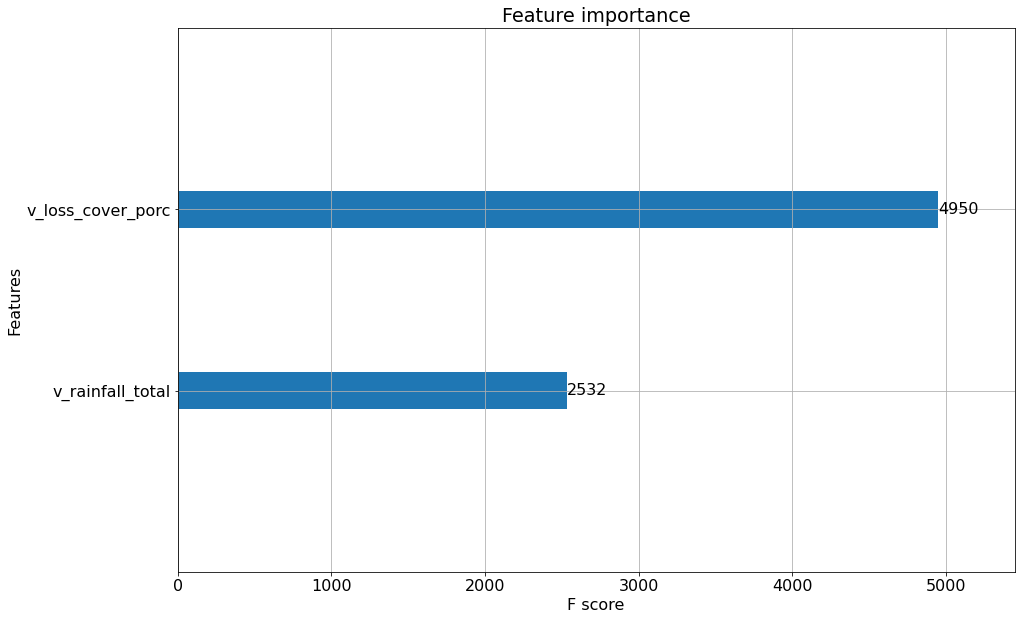

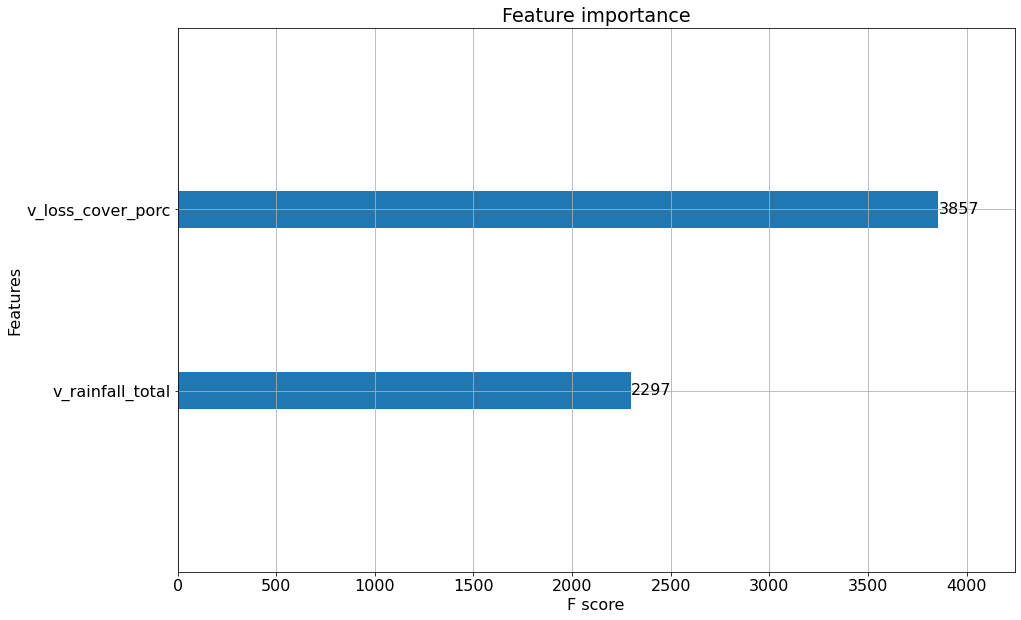

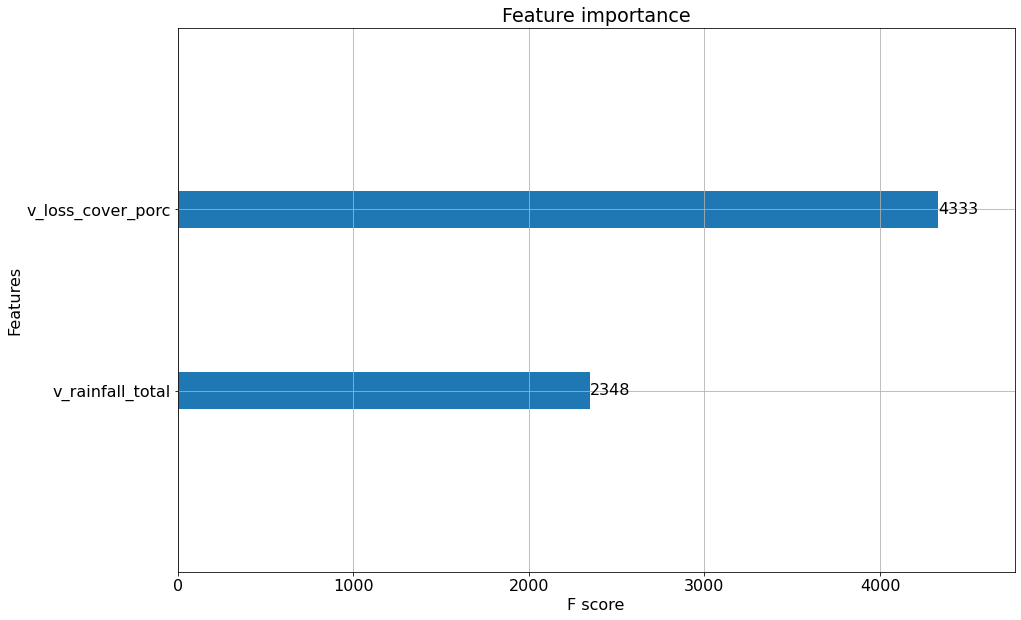

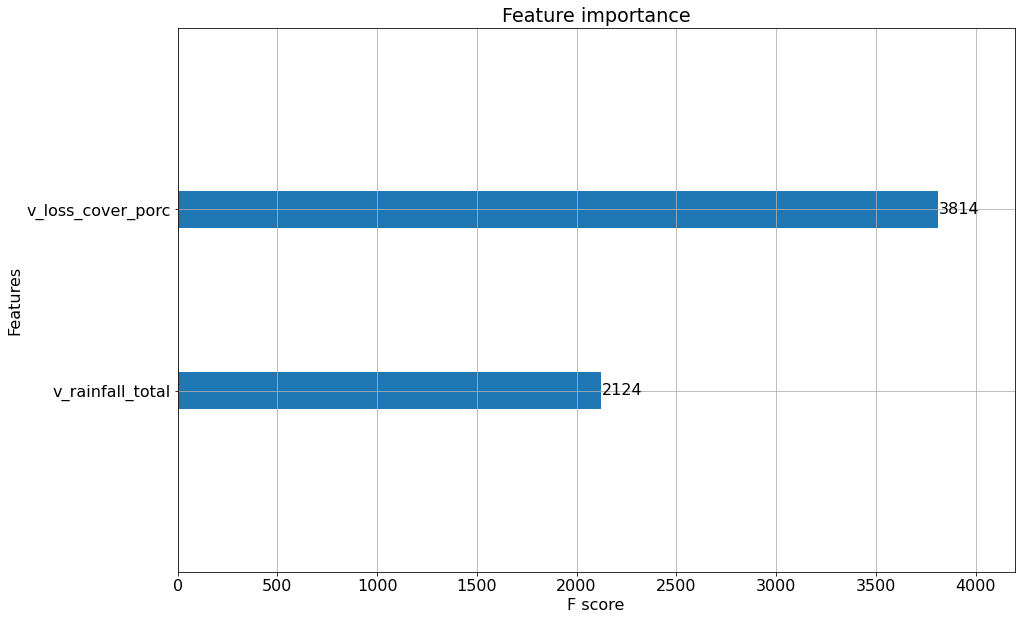

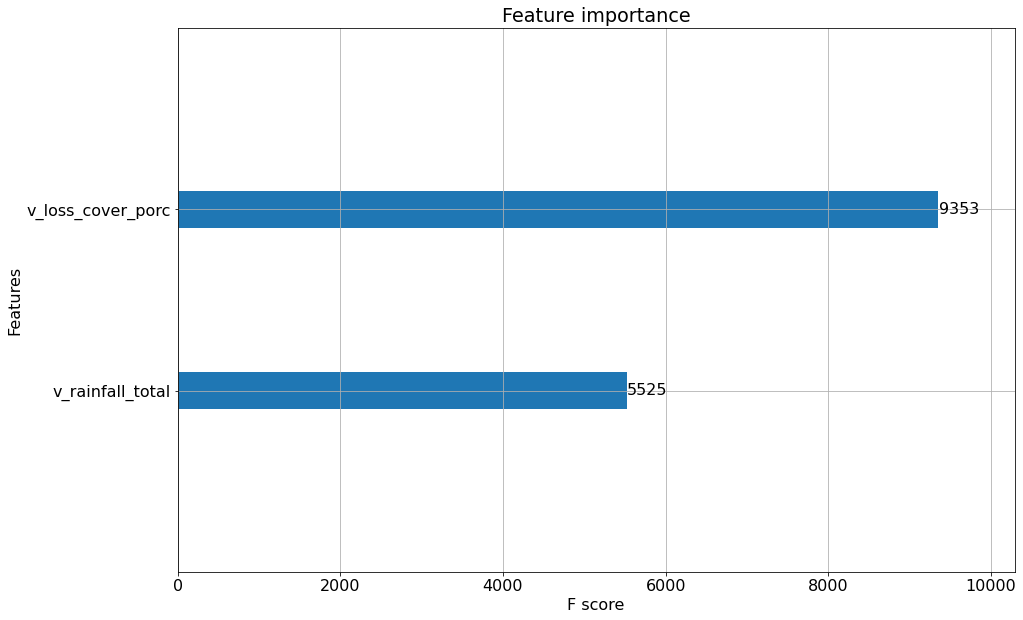

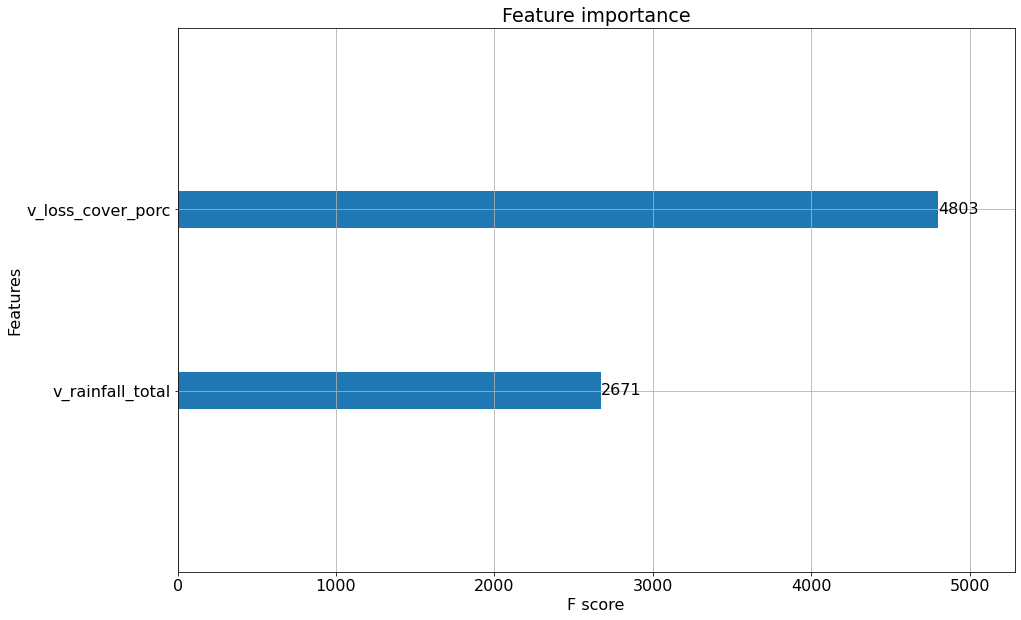

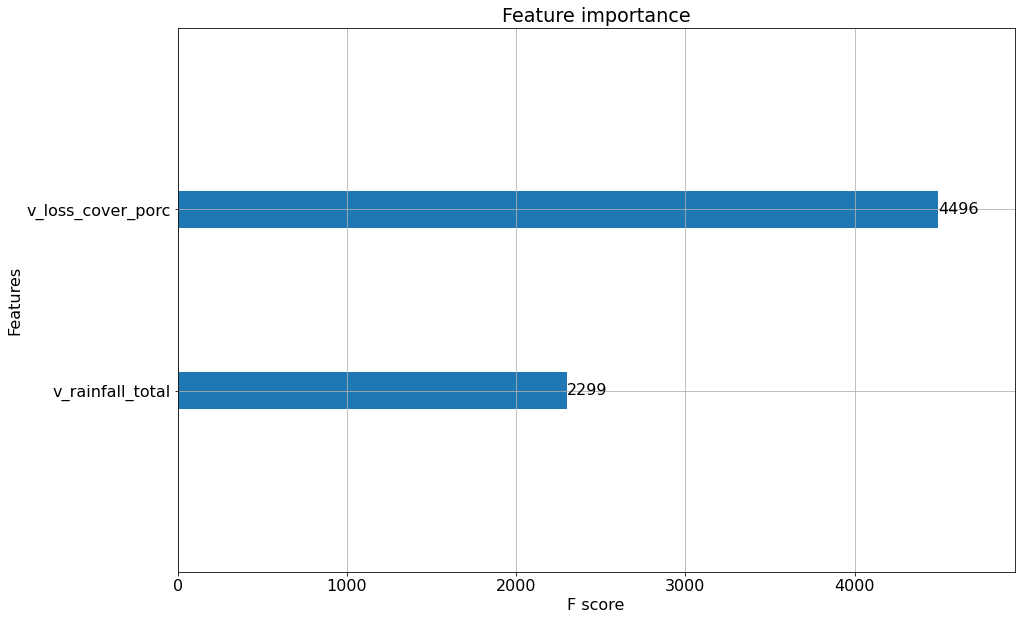

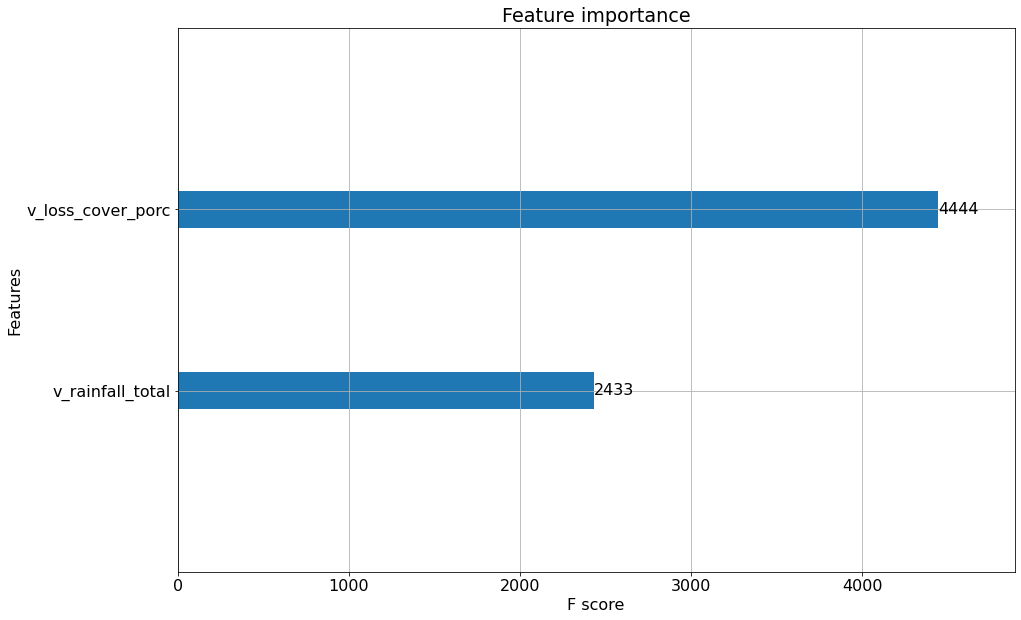

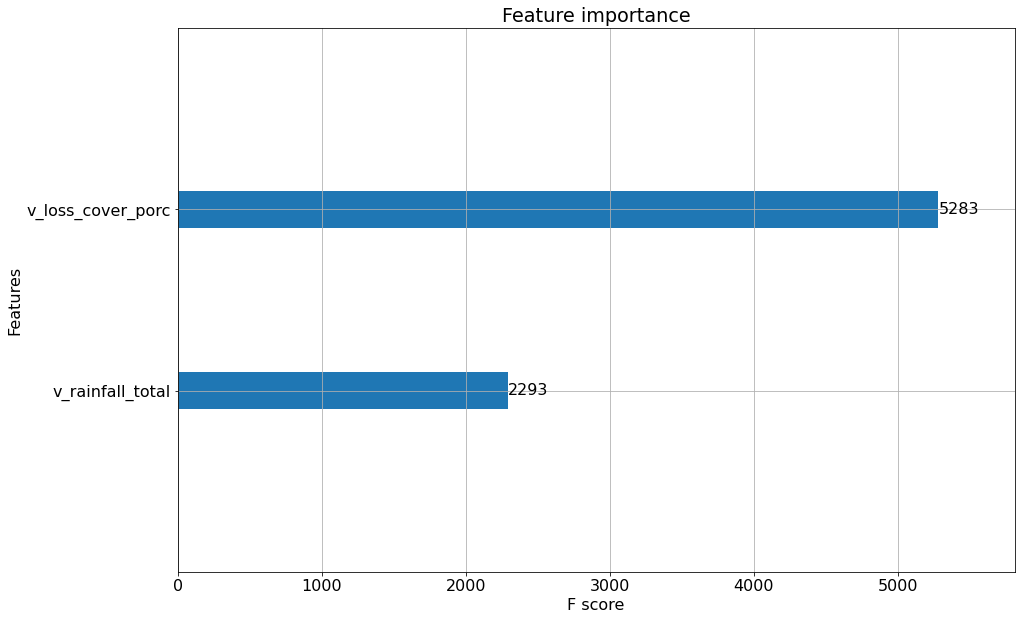

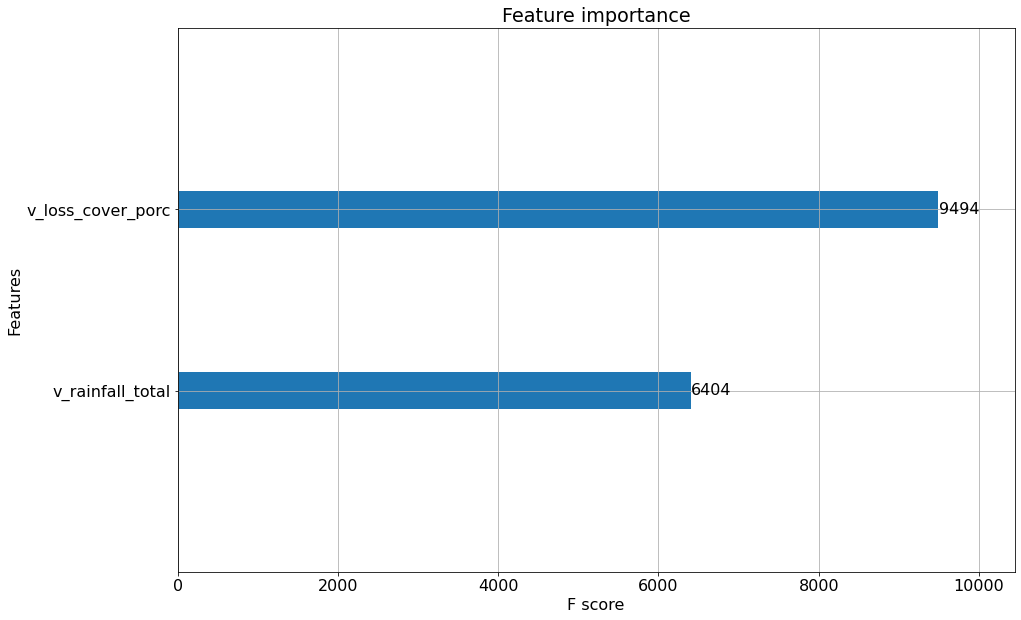

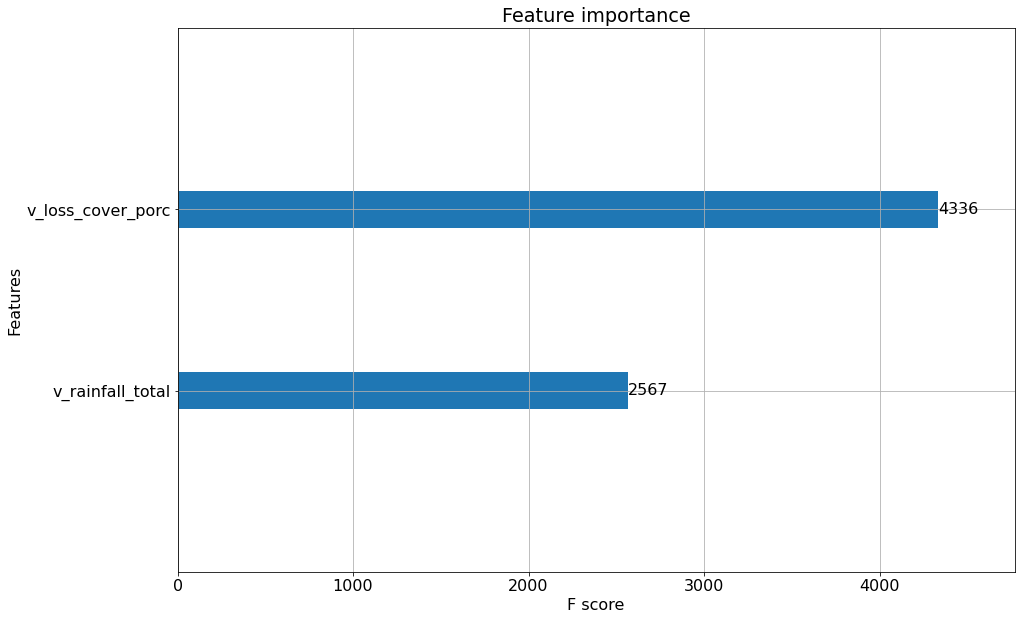

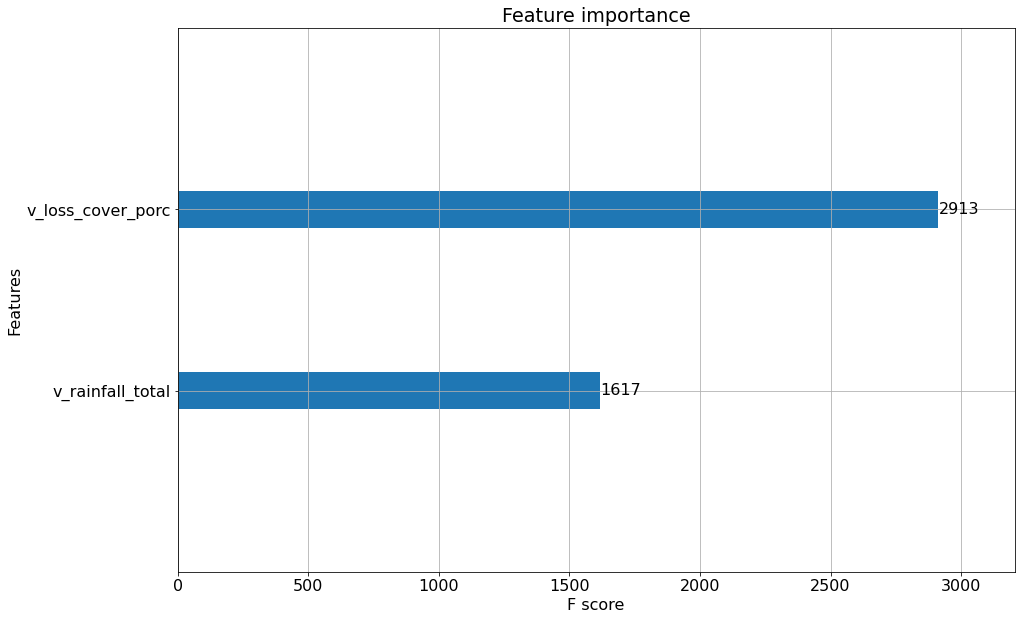

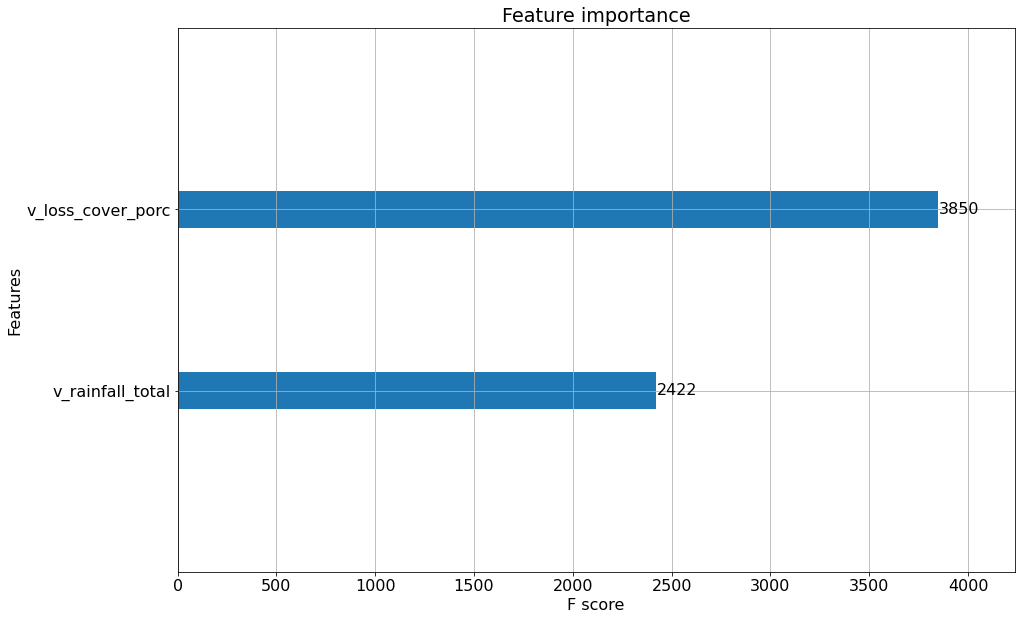

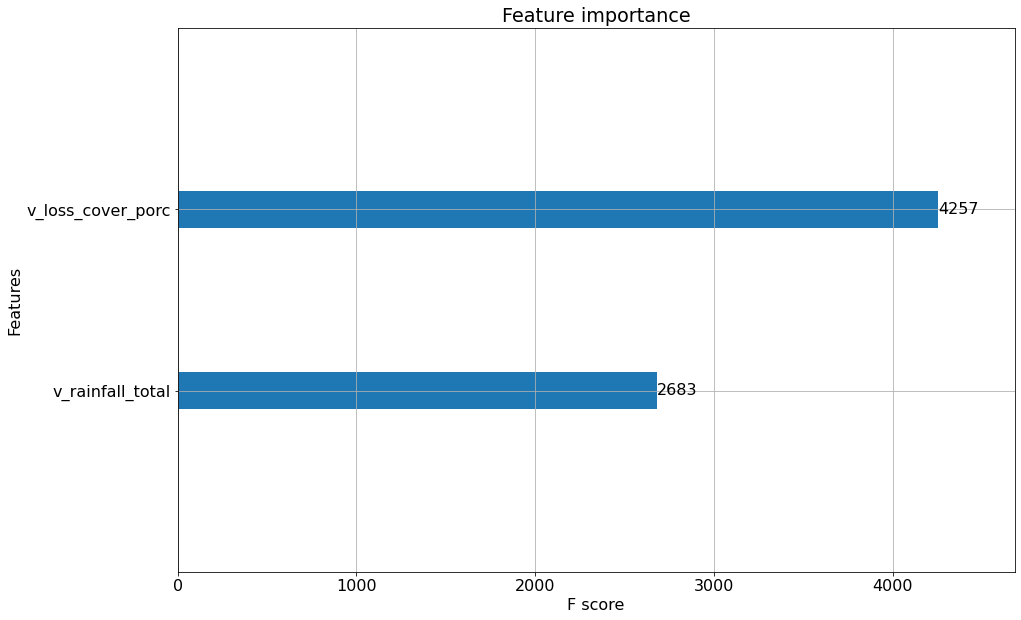

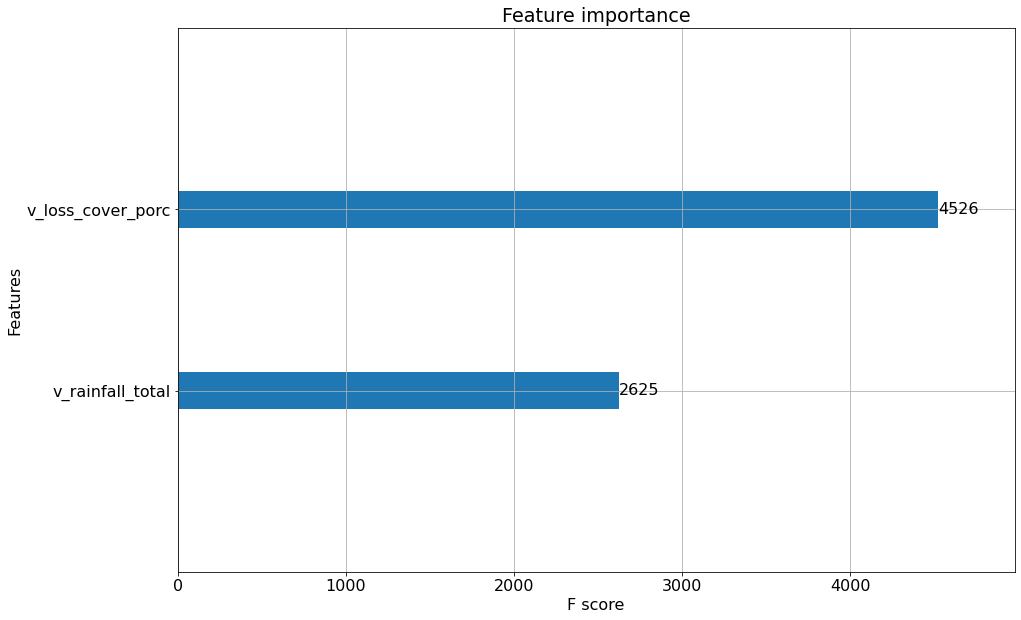

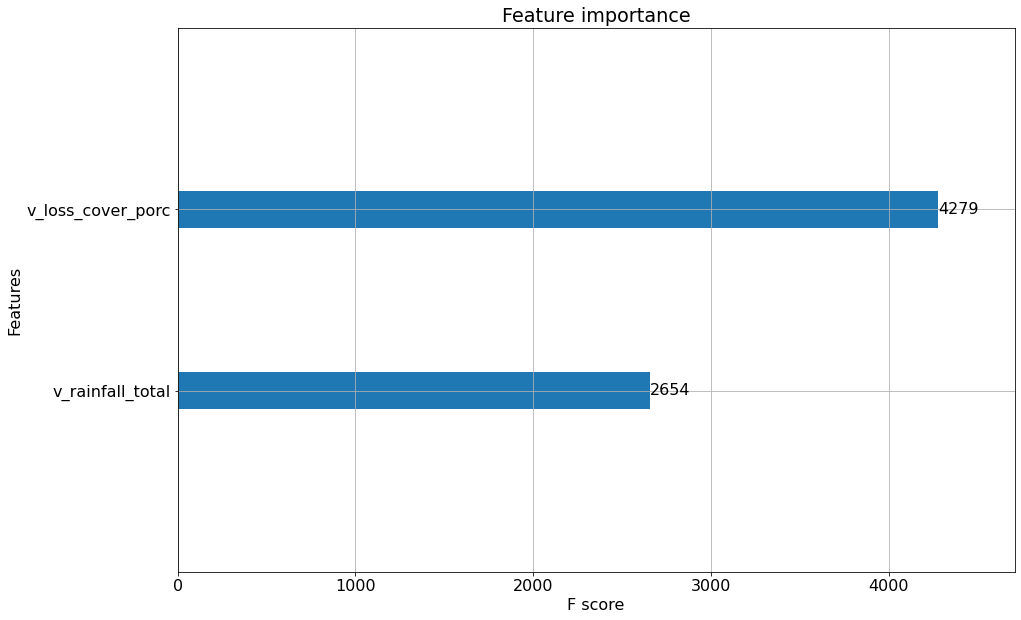

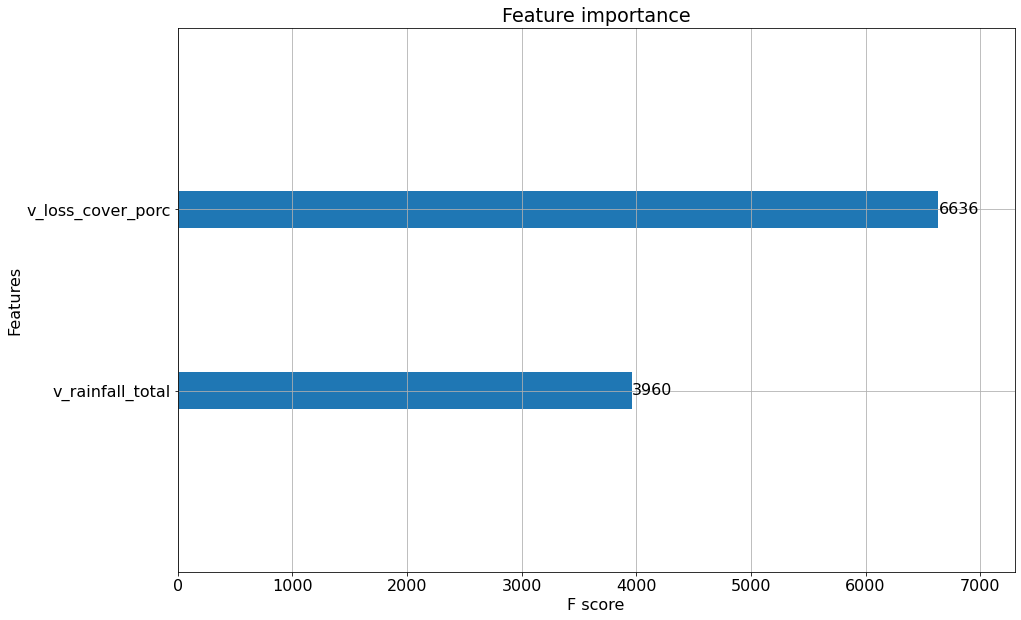

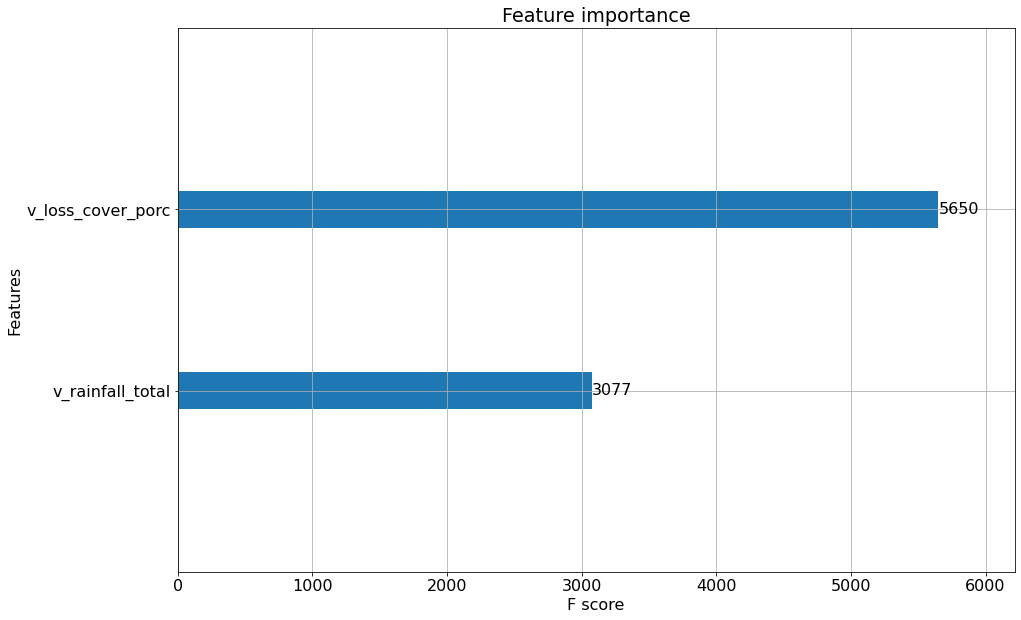

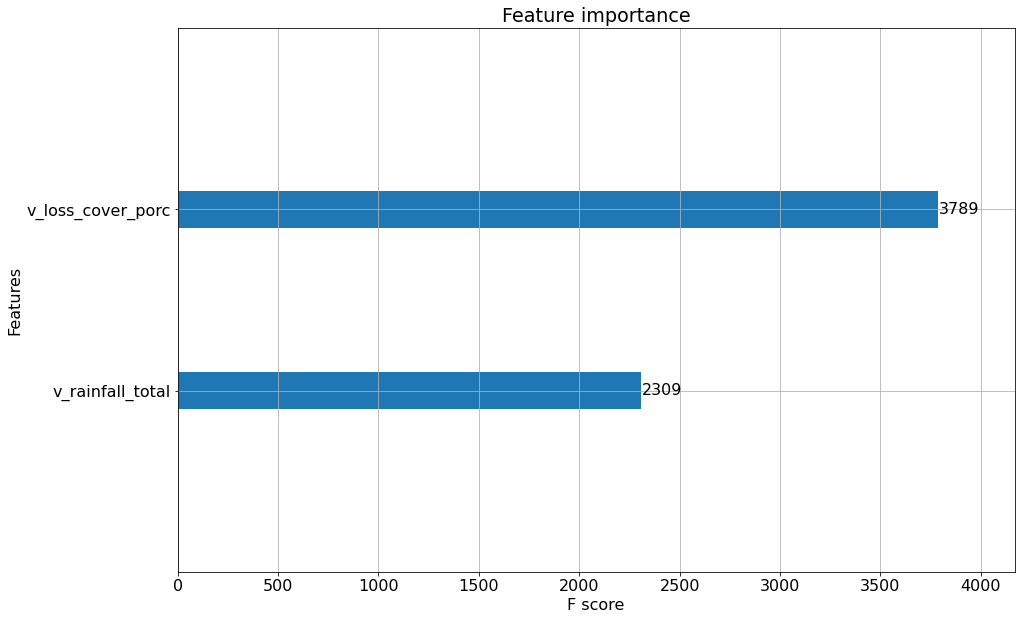

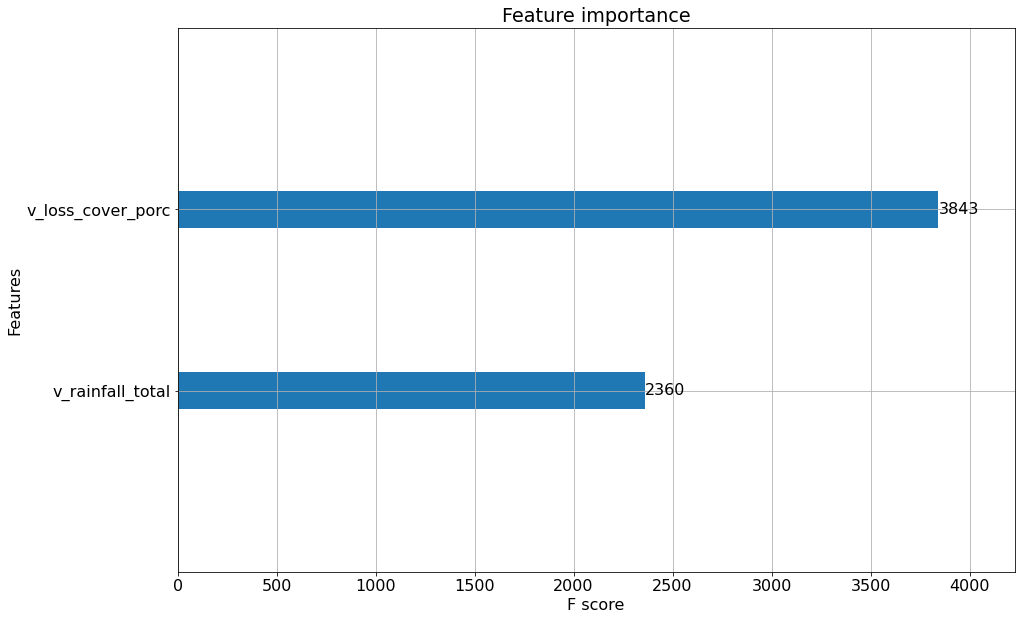

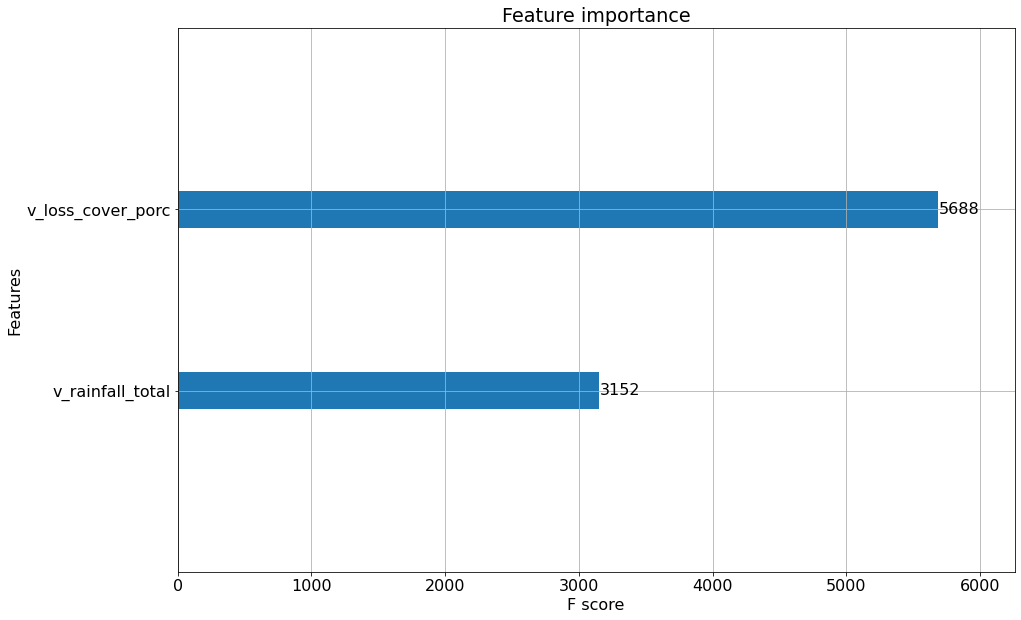

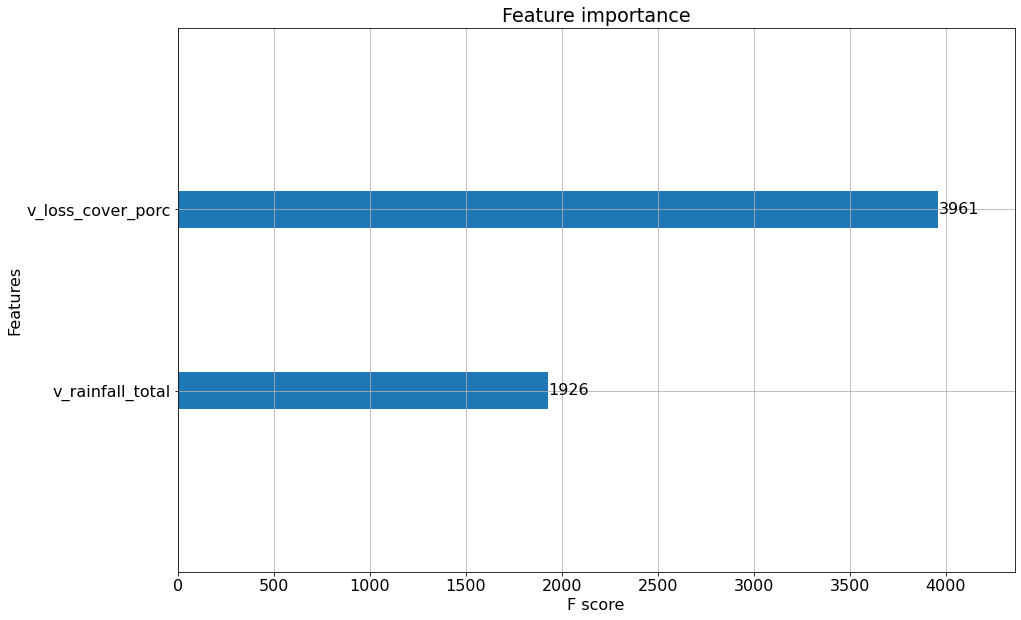

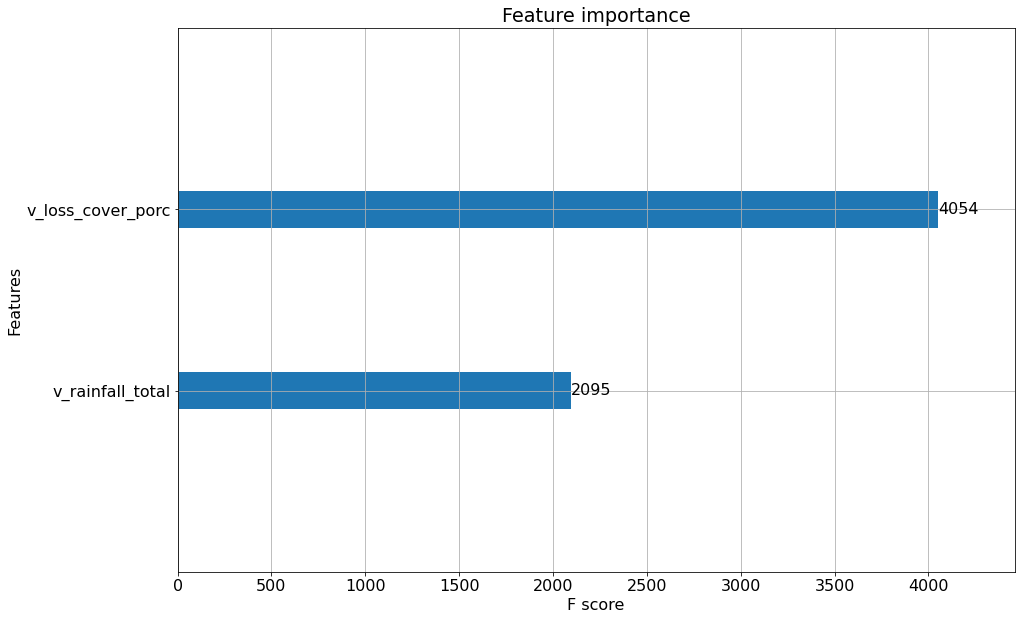

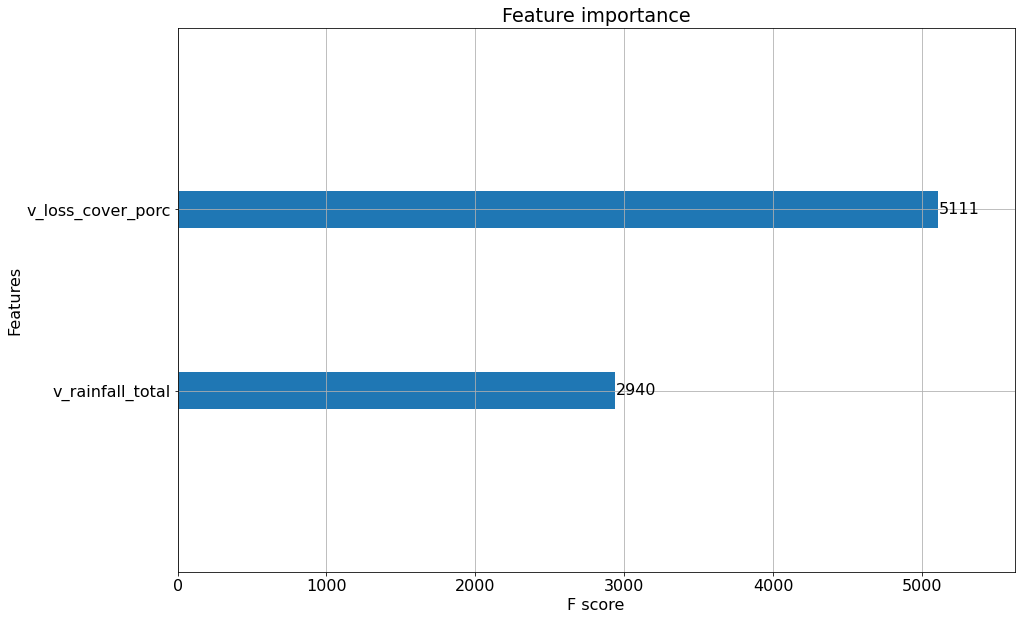

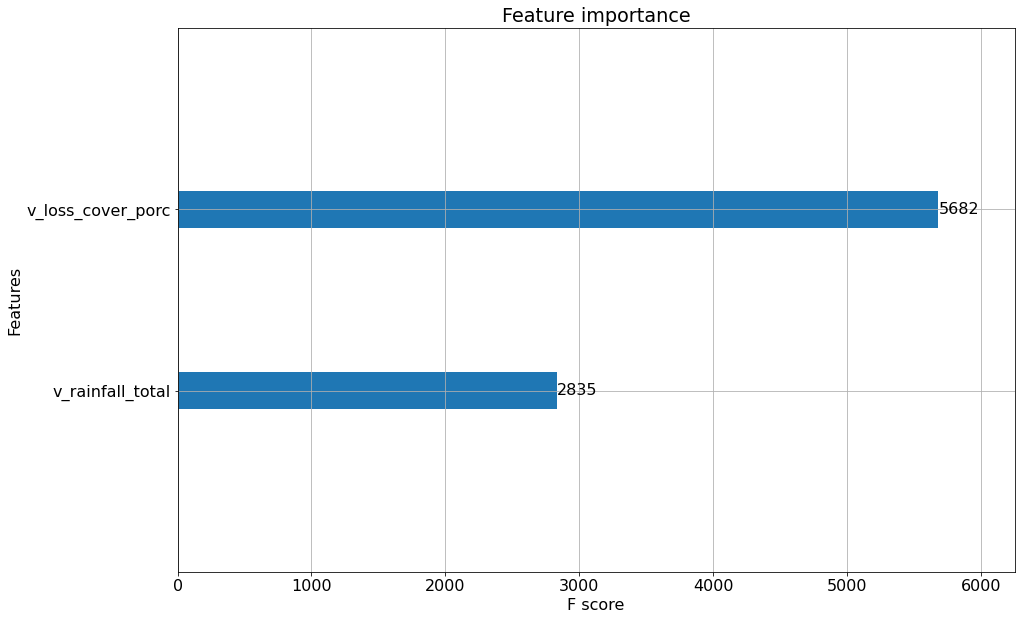

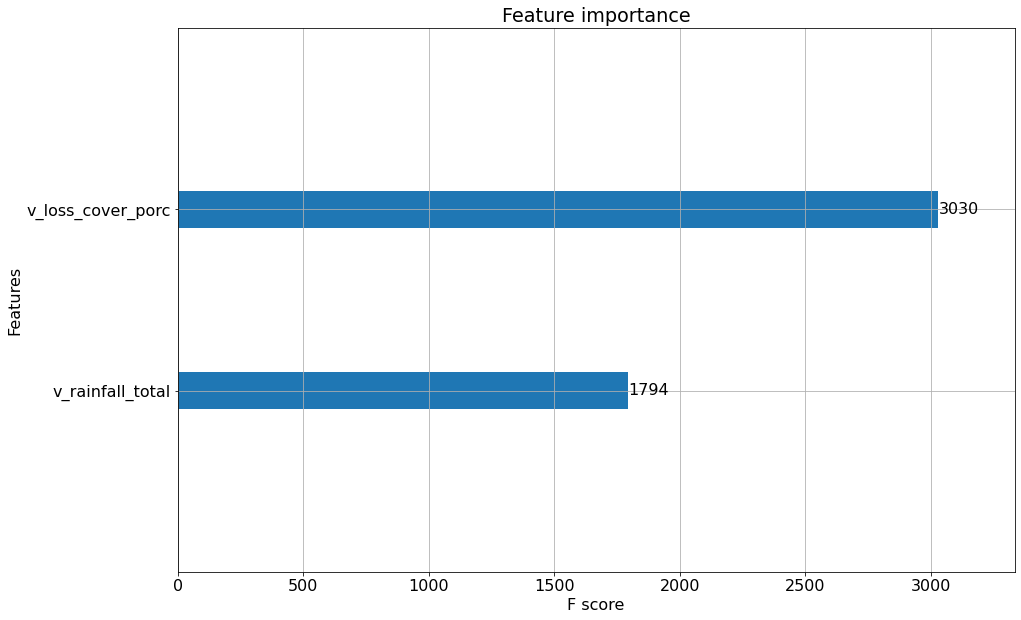

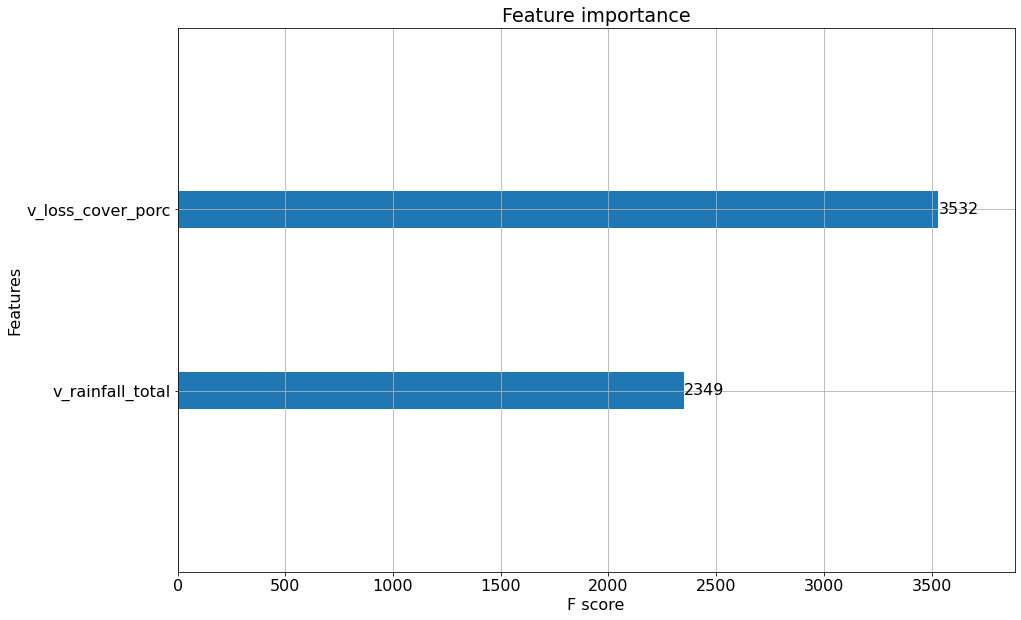

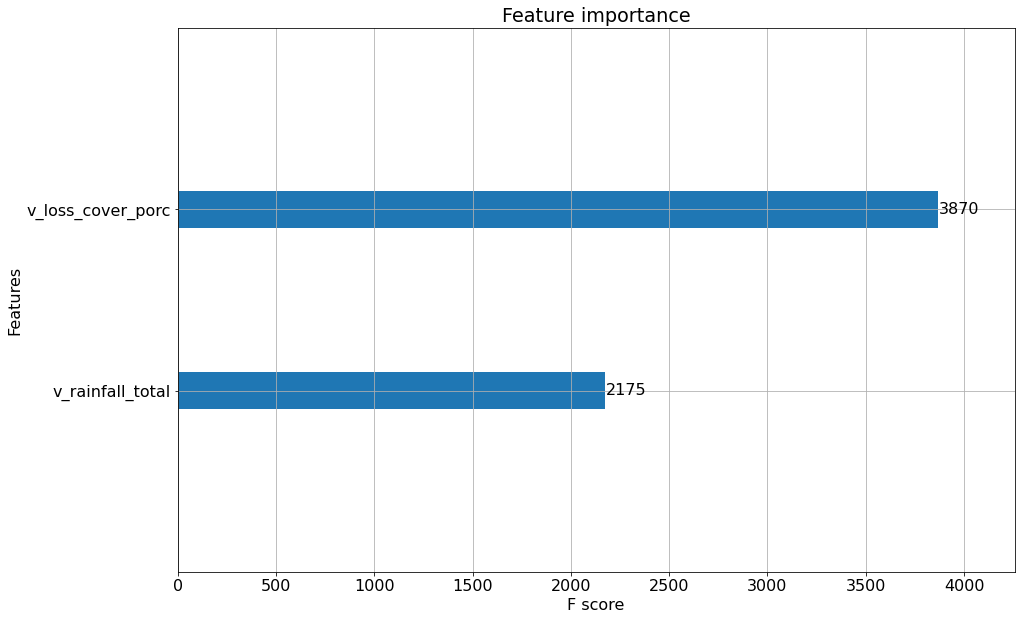

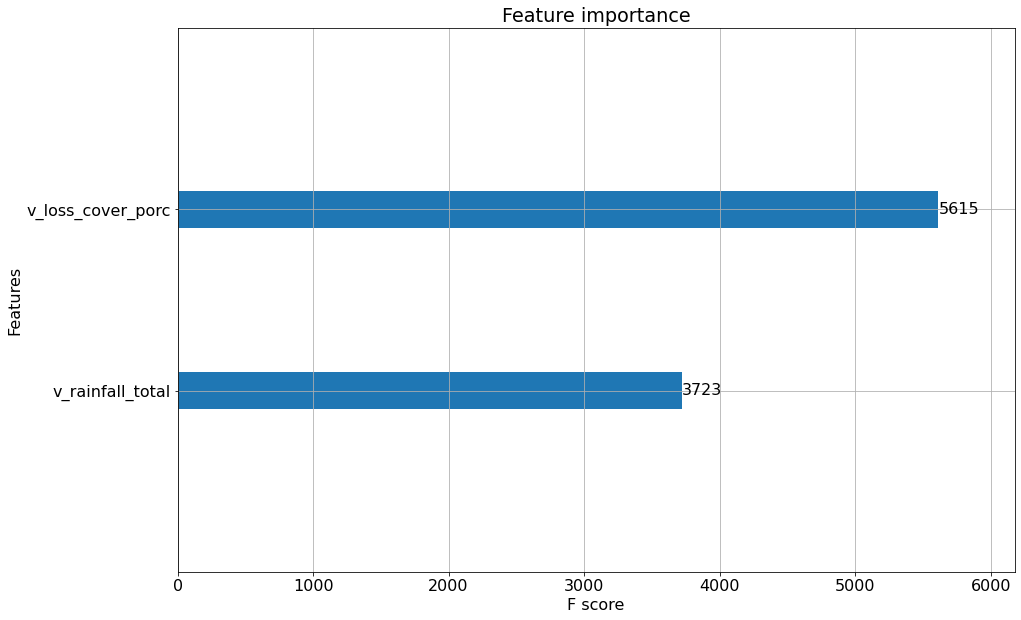

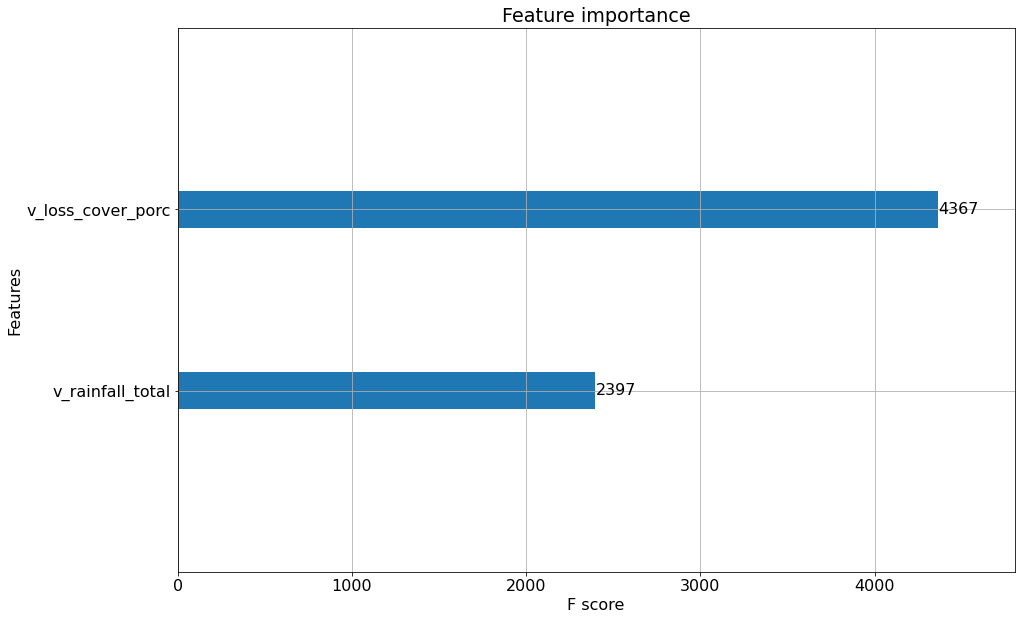

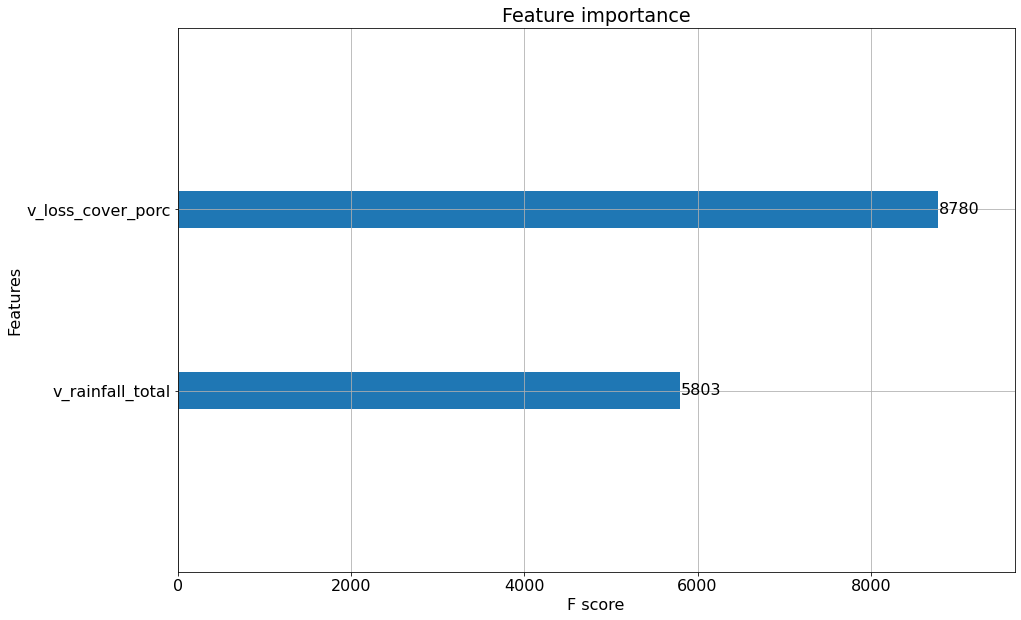

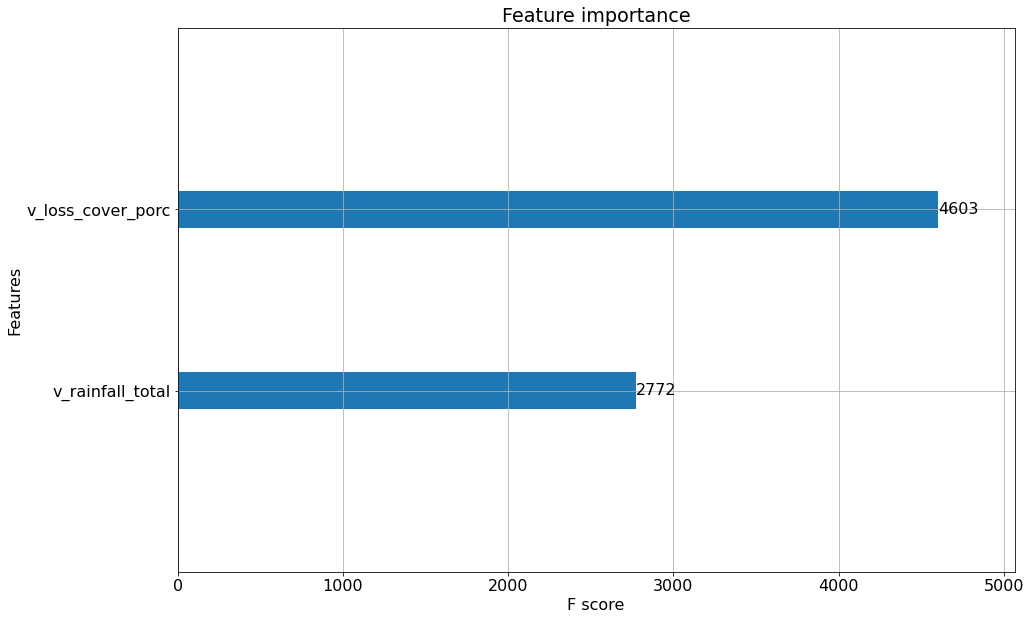

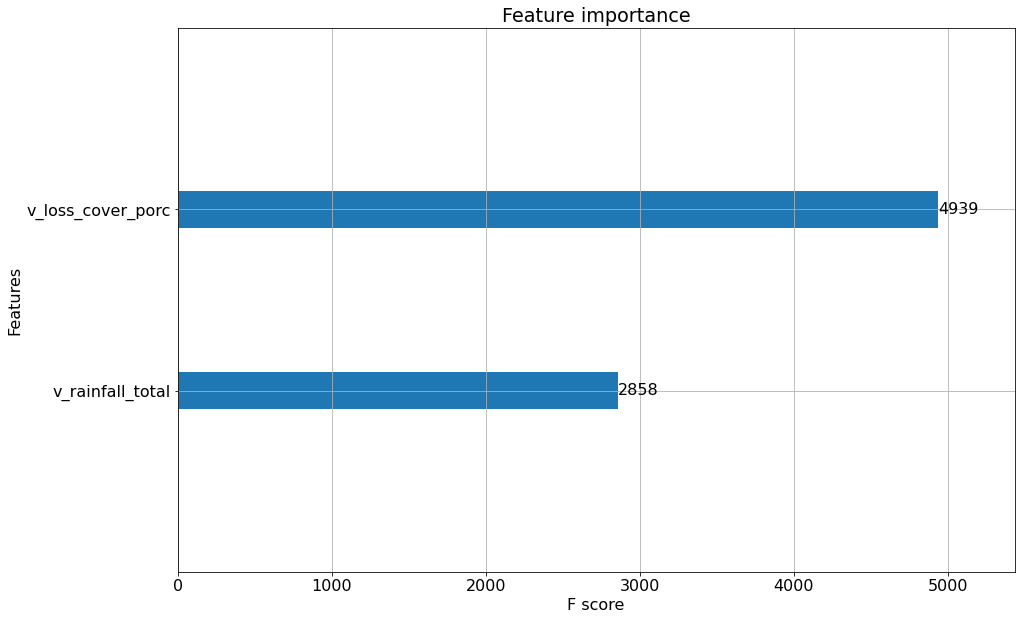

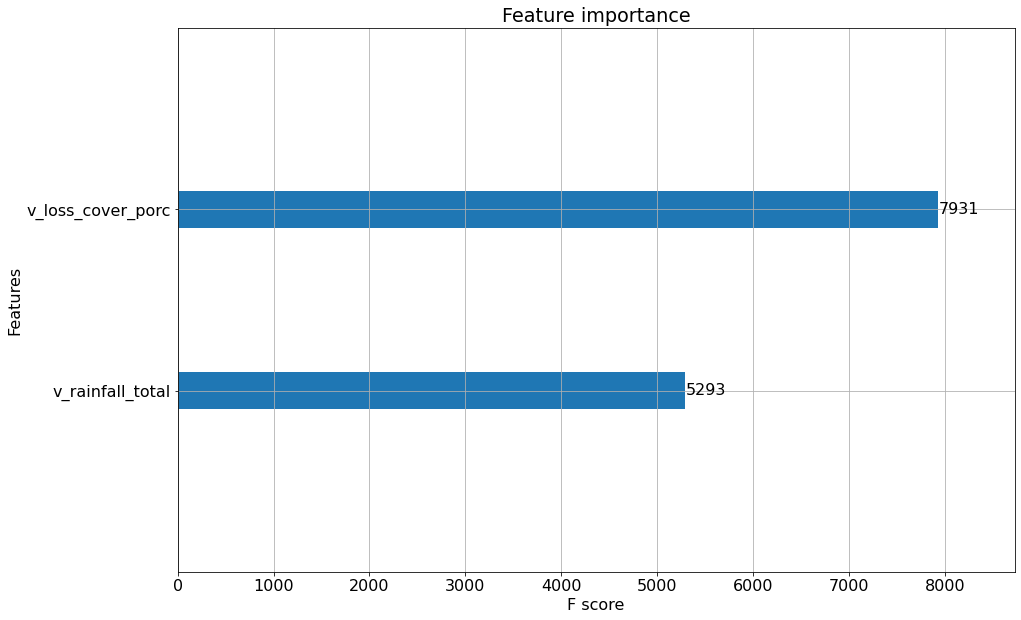

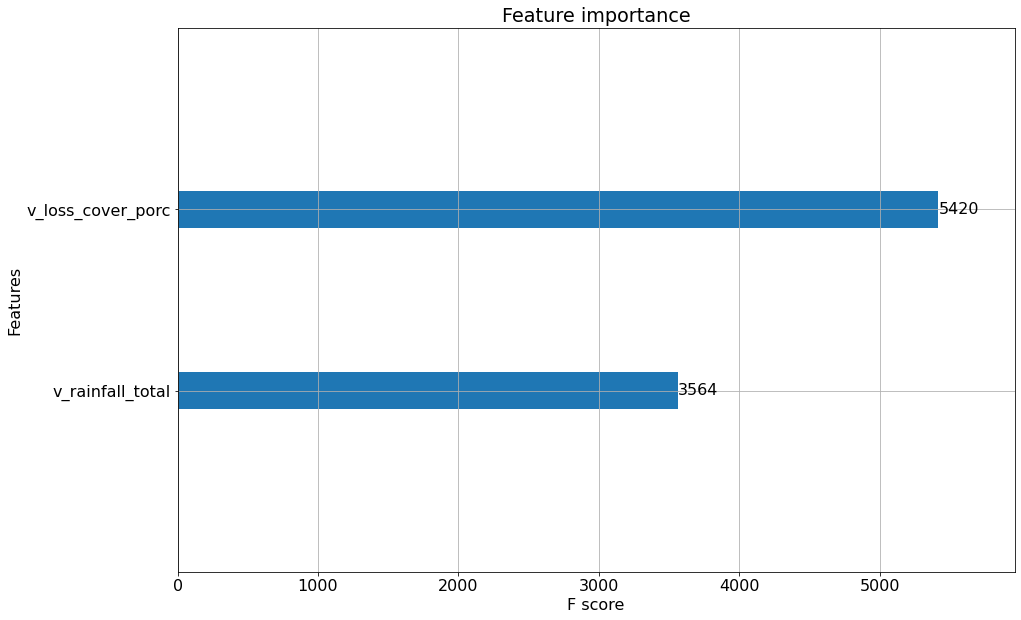

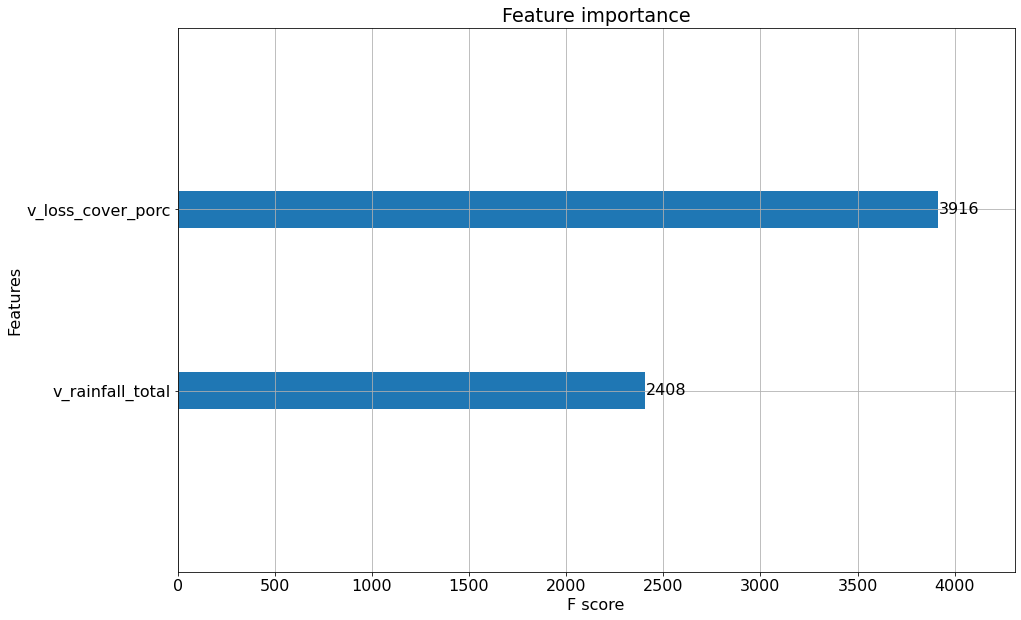

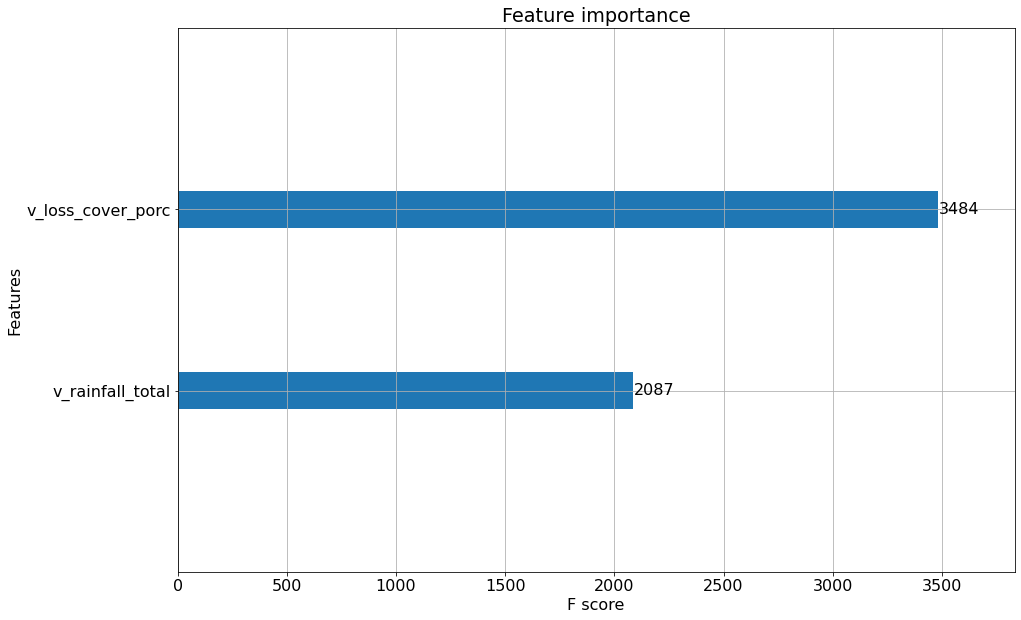

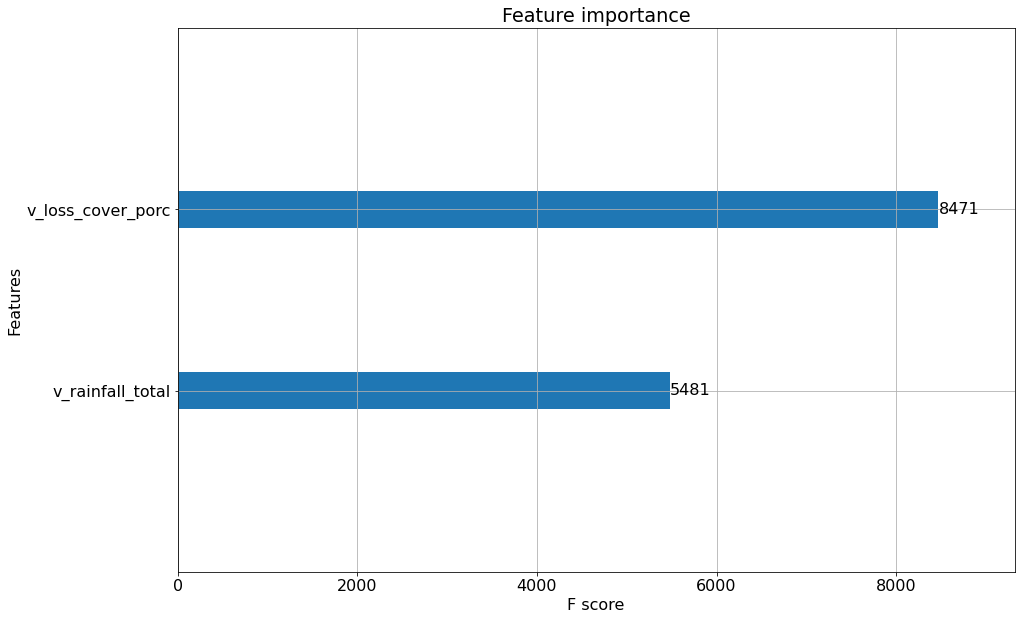

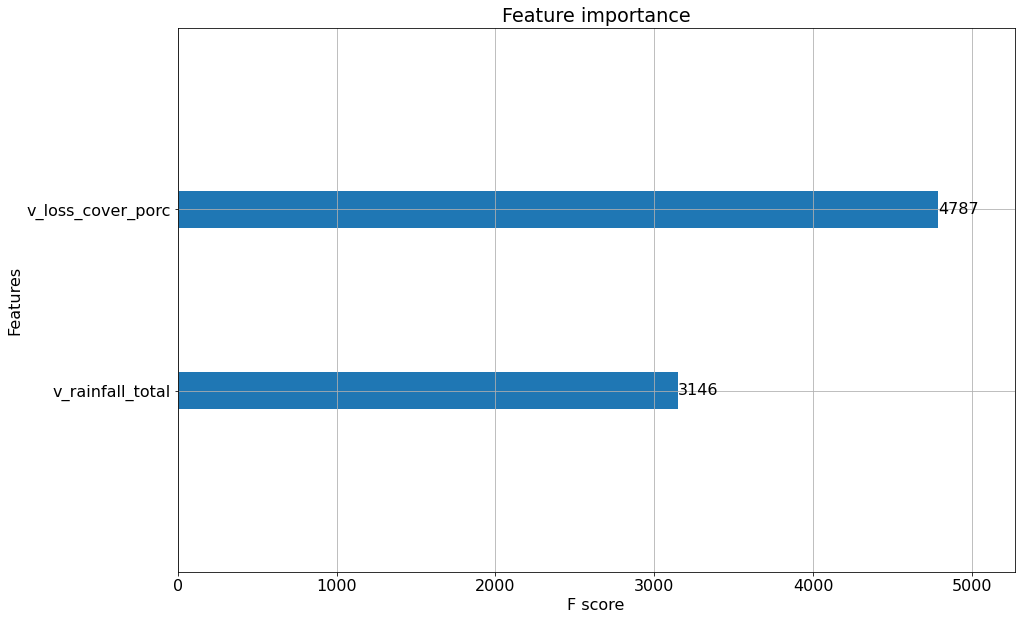

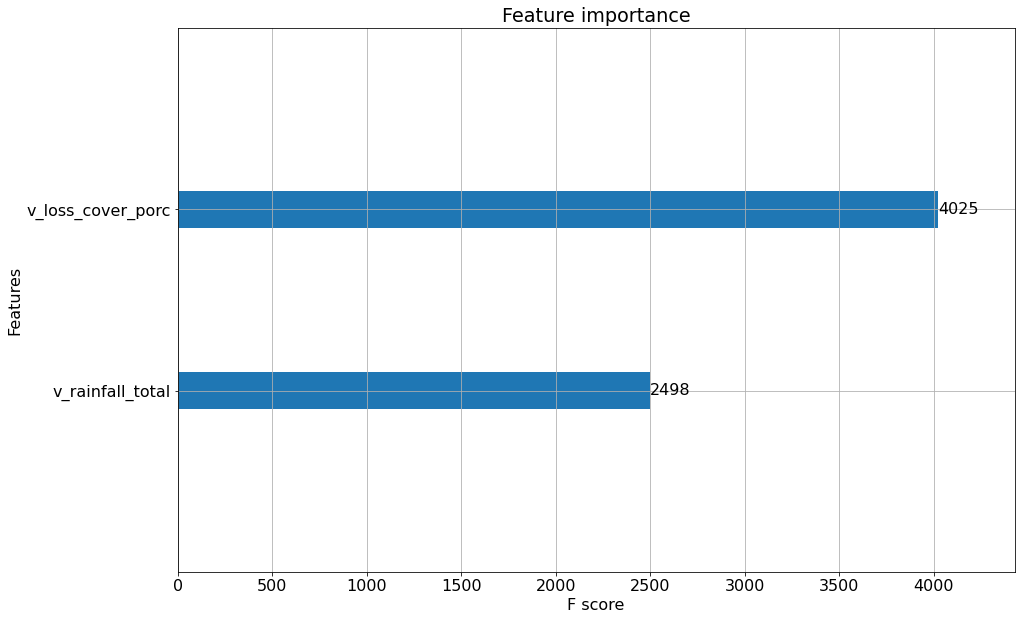

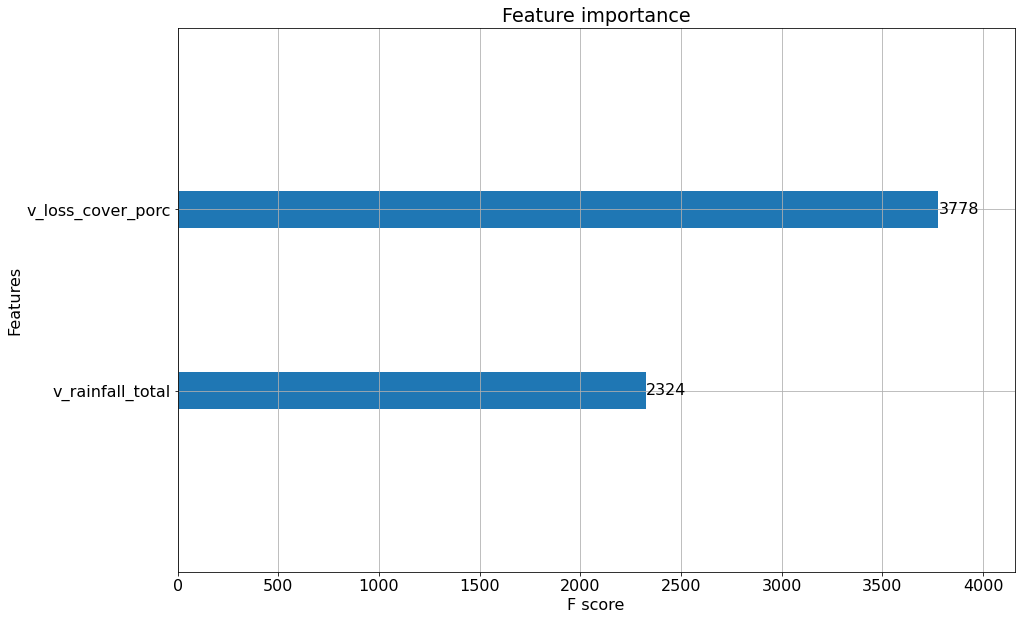

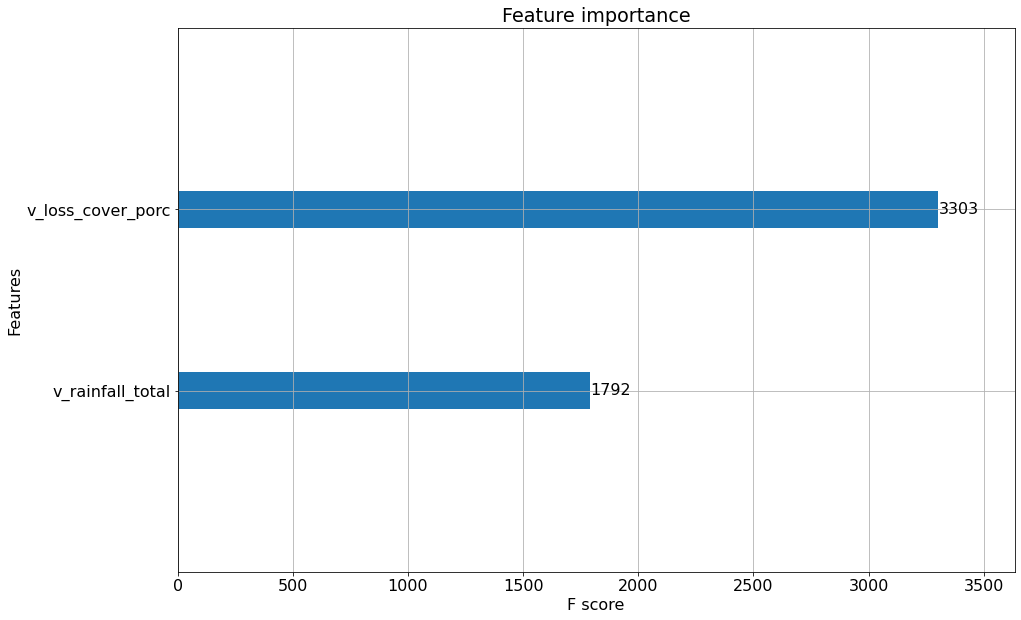

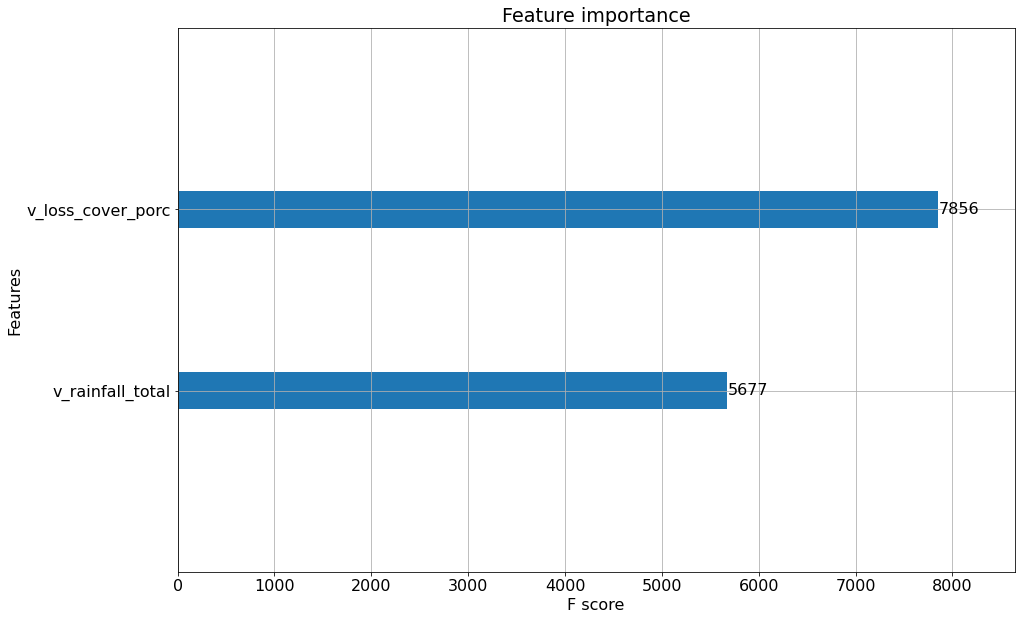

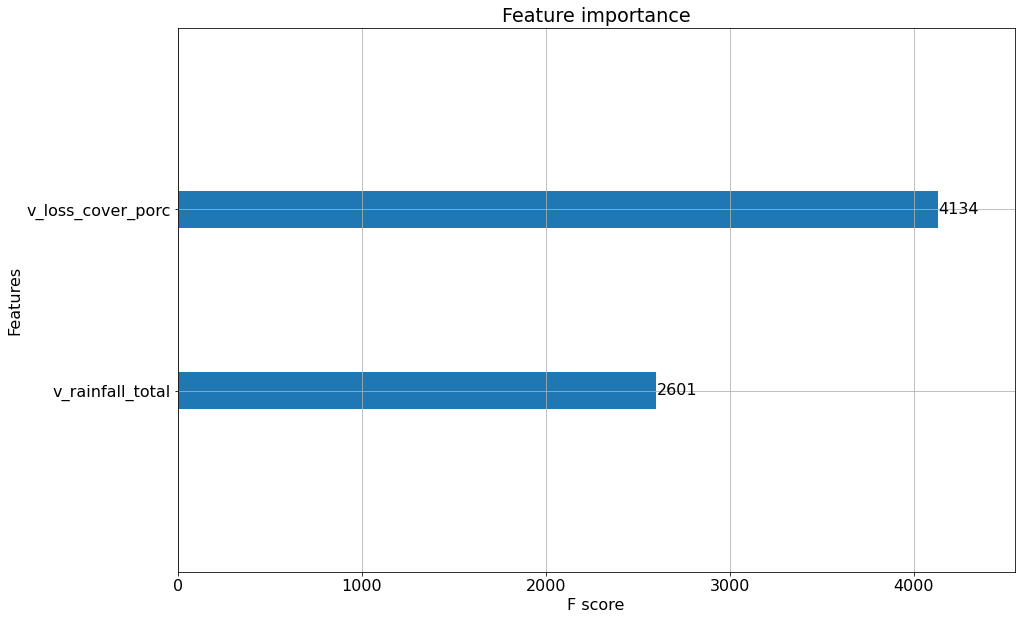

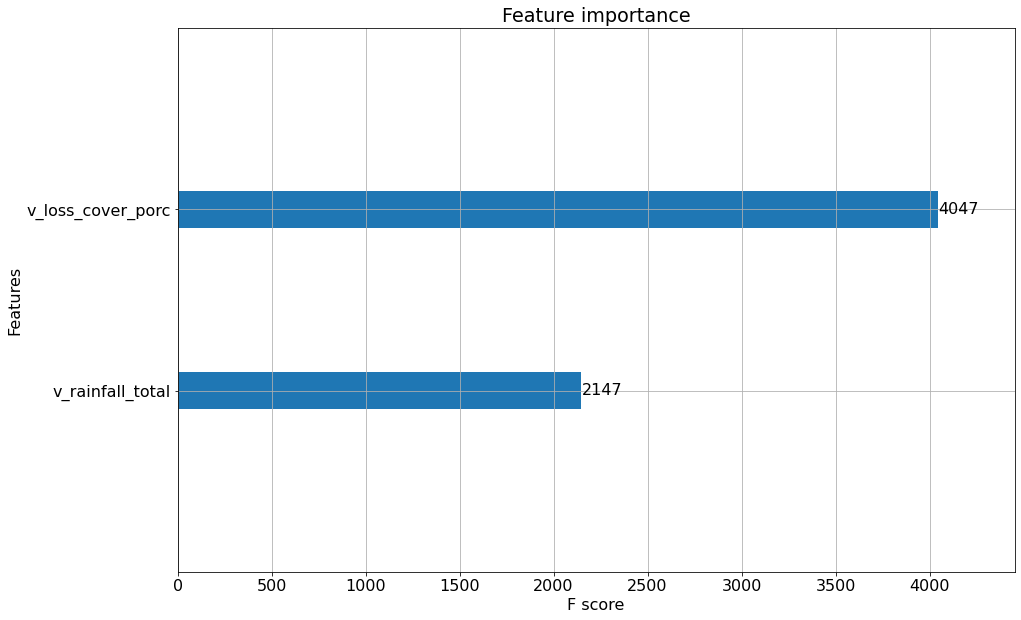

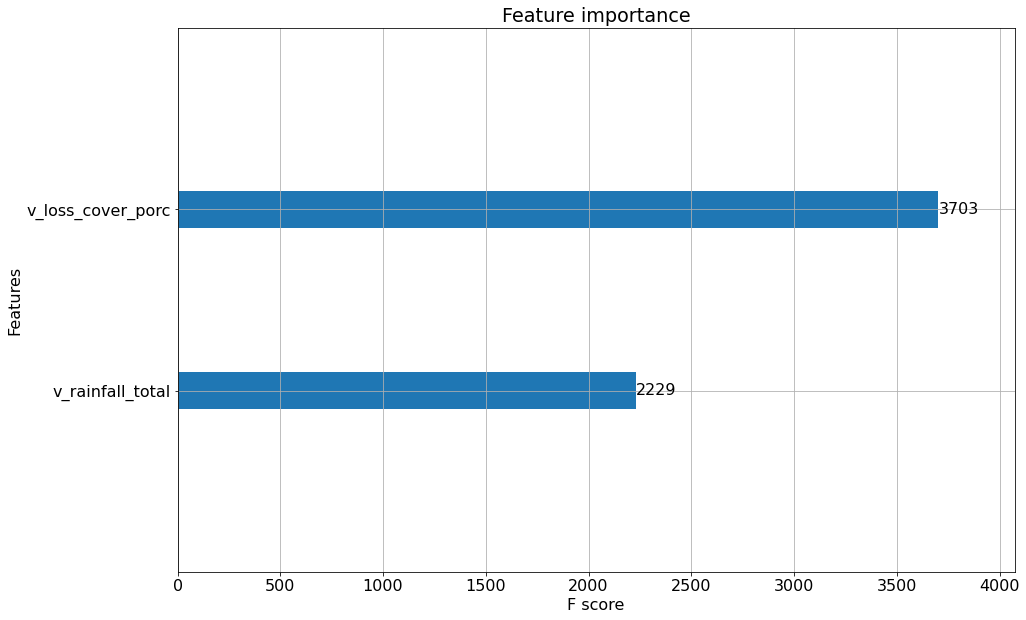

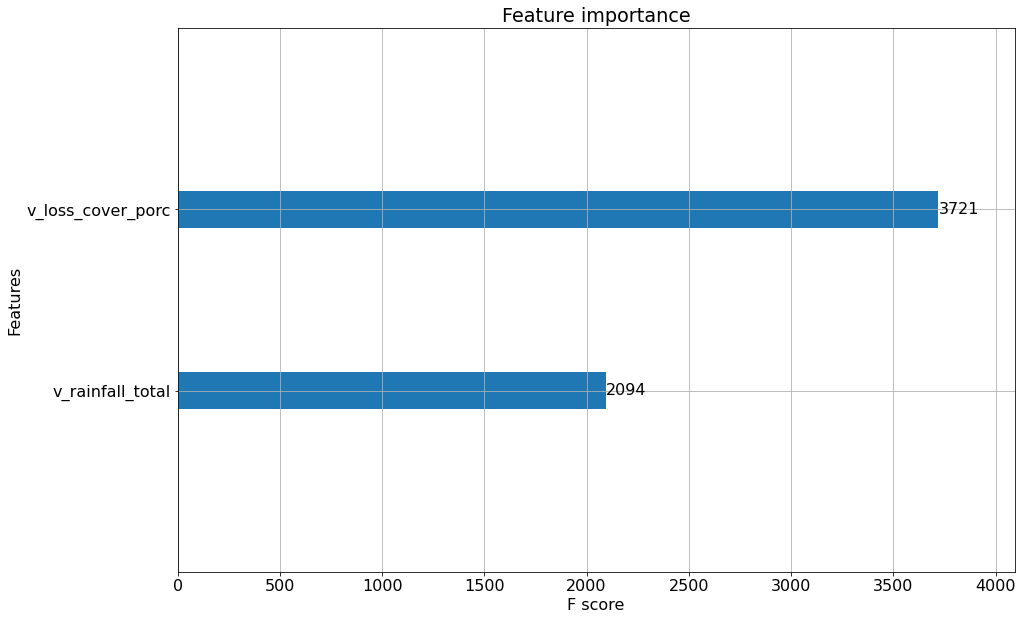

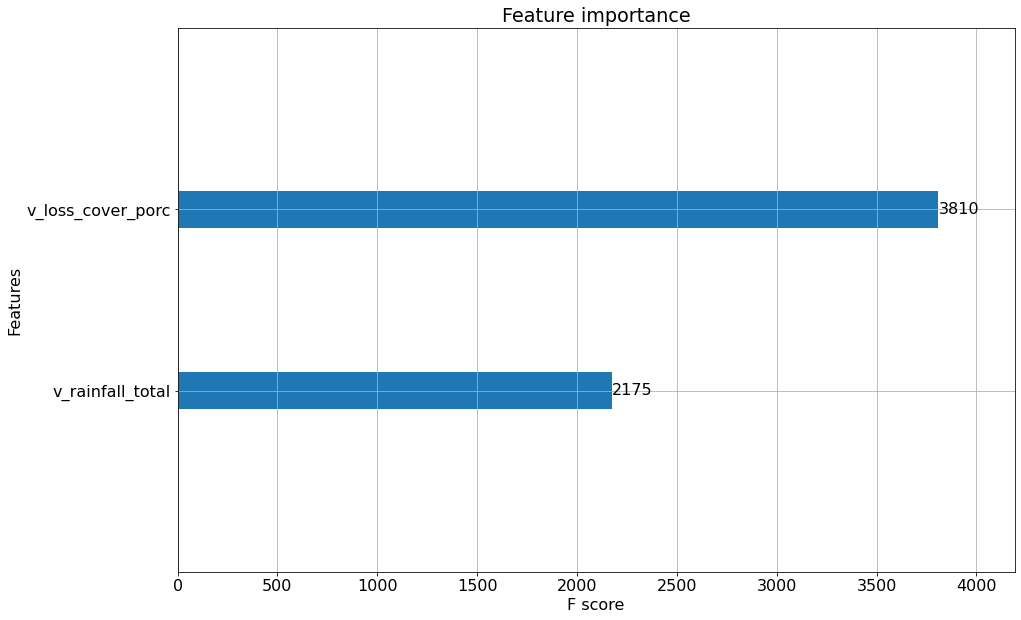

In [14]:
# XGB with xgboost library (First simplified version just with train - Version 1)

forecast_steps = 24

XGB_metrics = pd.DataFrame()
XGB_prediction = pd.DataFrame()

df_forecast = pd.DataFrame()

for i in mcs:
    X_train = data_train[data_train['mc'] == i].copy()
    y_train = np.log(X_train.v_flow_mean[X_train['mc'] == i] + 0.01)
    X_test = data_test[data_test['mc'] == i].copy()
    y_test = np.log(X_test.v_flow_mean[data_test['mc'] == i] + 0.01)
    y_test_org = X_test.v_flow_mean[data_test['mc'] == i] + 0.01
    
    dtrain = xgb.DMatrix(X_train[predictors], y_train)
    dtest = xgb.DMatrix(X_test[predictors], y_test)

    watchlist = [(dtrain, 'train'), (dtest, 'test')]

    print("\n=====================================")
    print('MC = %s' % i)
    print("=====================================\n")
    
    xgb_model = xgb.train(params, dtrain, 300, evals = watchlist, 
                          early_stopping_rounds = 100, feval = rmspe_xg, 
                          verbose_eval = False)

#     Funcional sin tunning *********

    yhat = xgb_model.predict(xgb.DMatrix(X_test[predictors]))
    error = rmspe(X_test.v_flow_mean.values, np.exp(yhat))

    print('First validation yelds RMSPE: {:.6f}'.format(error))
    print(yhat)
    
    xgb.plot_importance(xgb_model)    
    
    # predictions to unseen data
    unseen = xgb.DMatrix(X_test[predictors])
    test_p = xgb_model.predict(unseen)
    
    temp_df = data_test[data_test['mc'] == i].copy()
    temp_df = temp_df[['v_flow_mean', 'v_loss_cover', 'v_rainfall_total']]
    temp_df.reset_index(drop=True, inplace=True)
    
    forecast = pd.DataFrame({'v_flow_mean_mean': np.exp(test_p)})
    forecast = pd.concat([dates, forecast, temp_df], axis = 1)
    forecast['mc'] = i
    
    print(forecast.head())
    
    forecast_errors = [temp_df.v_flow_mean.iloc[j] - forecast.v_flow_mean_mean.iloc[j] 
                       for j in range(forecast_steps)]
    bias = sum(forecast_errors) * 1.0 / (forecast_steps)
#     print('Bias : %f' % bias)

    mae = skm.mean_absolute_error(temp_df.v_flow_mean, forecast.v_flow_mean_mean)
#     print('MAE : %f' % mae)

    mse = skm.mean_squared_error(temp_df.v_flow_mean, forecast.v_flow_mean_mean)
    rmse = np.sqrt(mse)
#     print('MSE : %f' % mse)
#     print('RMSE : %f' % rmse) 
    
    resultados = [i, bias, mae, mse, rmse]
    resultados = pd.DataFrame([resultados], columns = ['mc', 'Bias', 'MAE', 'MSE', 'RMSE'])
    
    print(resultados.head())
    print('===========================================================\n')

    forecast = forecast[['date', 'year', 'month', 'mc', 'v_flow_mean_mean', 
                         'v_flow_mean', 'v_loss_cover', 'v_rainfall_total']]
    
    XGB_metrics = pd.concat([XGB_metrics, resultados], axis = 0)
    XGB_prediction = pd.concat([XGB_prediction, forecast], axis = 0)
    
#     print(y_test_org.head())

#     ******************************************************************
    
#     Prueba ******
    
#     params_sk = {'max_depth': 10, 
#             'n_estimators': 100, # the same as num_rounds in xgboost
#             'objective': 'reg:squarederror', 
#             'subsample': 0.8, 
#             'colsample_bytree': 0.85, 
#             'learning_rate': 0.025, 
#             'seed': 42}     

#     skrg = XGBRegressor(**params_sk)

#     skrg.fit(X_train[predictors], y_train, 
#              eval_set = [(X_train[predictors], y_train), (X_test[predictors], y_test)])

#     results = skrg.evals_result()
#     epochs = len(results['validation_0']['rmse'])
#     x_axis = range(0, epochs)
#     # plot AUC
#     fig, ax = plt.subplots()
#     ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
#     ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
#     ax.legend()
#     plt.ylabel('RMSE')
#     plt.title('XGBoost RMSE')
#     plt.show()
        
    
#     ******************************************************************
    

# Guardar en archivos

XGB_metrics.to_csv('../model/XGB_results_v1.csv', index = False)
XGB_metrics.head()

XGB_prediction.to_csv('../model/XGB_predictions_v1.csv', index = False)
XGB_prediction.head()
 

------------------------

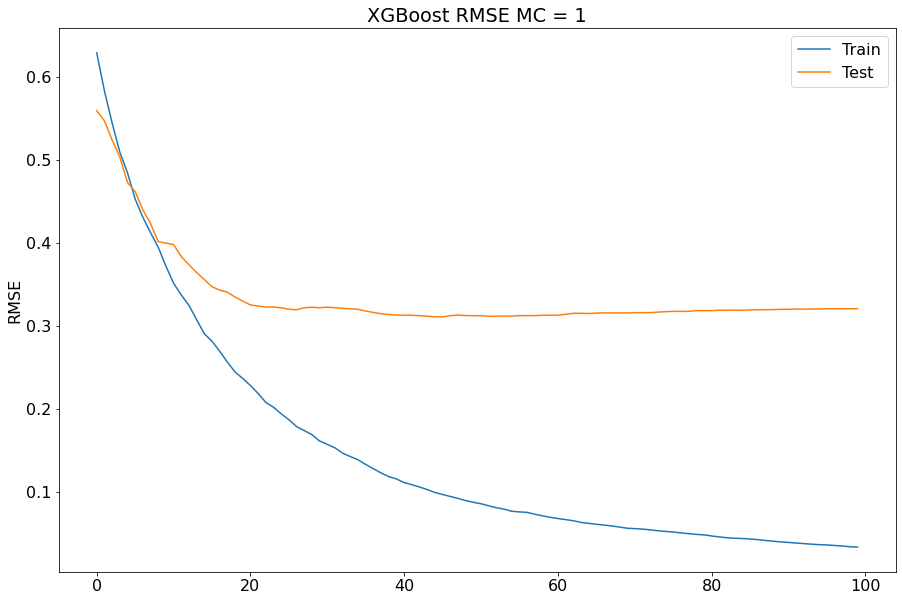

{'booster': 'gbtree', 'objective': 'reg:squarederror', 'subsample': 0.8, 'colsample_bytree': 0.85, 'eta': 0.05, 'max_depth': 14, 'gamma': 0.8, 'reg_alpha': 22, 'seed': 42}
First validation yelds RMSPE: 0.315697
[0.7978872 0.7978872 0.7978872 0.7978872 0.7978872 0.7978872 0.7978872
 0.7978872 0.7978872 0.7978872 0.7978872 0.7978872 0.7978872 0.7978872
 0.7978872 0.7978872 0.7978872 0.7978872 0.7978872 0.7978872 0.7978872
 0.7978872 0.7978872 0.7978872]
        date  year  month  v_flow_mean_mean  v_flow_mean  v_loss_cover  \
0 2018-01-01  2018      1          3.164513         1.60      0.072060   
1 2018-02-01  2018      2          2.721048         1.57      0.072256   
2 2018-03-01  2018      3          2.655977         2.10      0.072453   
3 2018-04-01  2018      4          2.436255         2.99      0.072649   
4 2018-05-01  2018      5          3.240294         3.40      0.072846   

   v_rainfall_total  mc  
0            222.87   1  
1            143.49   1  
2            274.72  

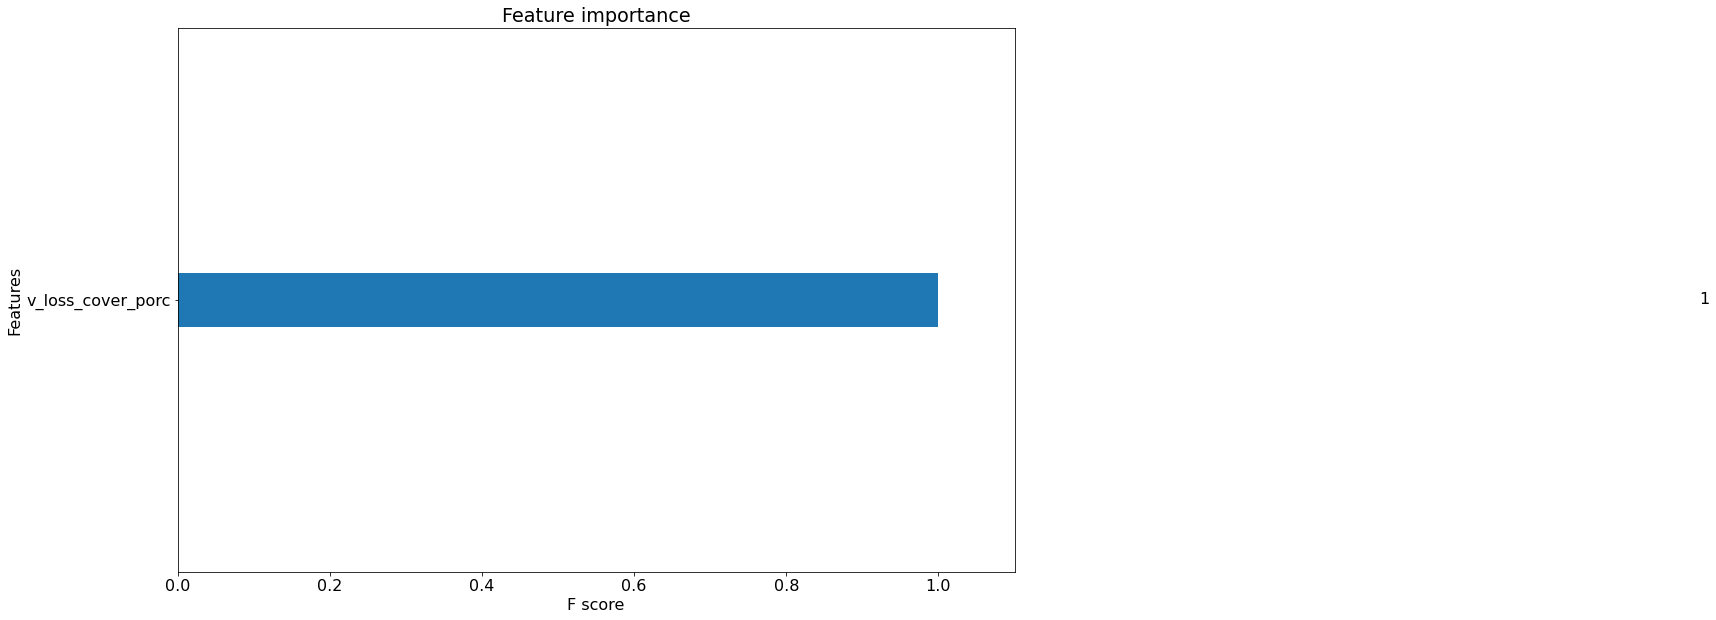

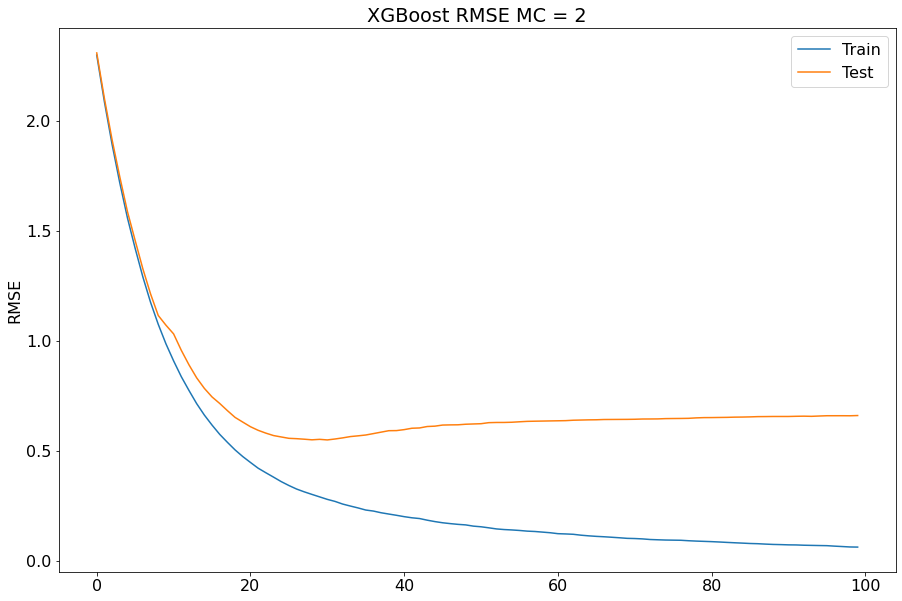

{'booster': 'gbtree', 'objective': 'reg:squarederror', 'subsample': 0.8, 'colsample_bytree': 0.85, 'eta': 0.05, 'max_depth': 14, 'gamma': 1, 'reg_alpha': 22, 'seed': 42}
First validation yelds RMSPE: 0.751166
[2.9035223 2.8470042 2.9035223 2.9035223 2.9035223 2.9035223 2.9035223
 2.7537143 2.4435432 2.8741732 2.9035223 2.9035223 2.4435432 2.6726868
 2.9035223 2.9035223 2.9035223 2.9035223 2.7537143 2.7433255 2.0051703
 2.8470042 2.9035223 2.9035223]
        date  year  month  v_flow_mean_mean  v_flow_mean  v_loss_cover  \
0 2018-01-01  2018      1         29.904297        33.51      0.050399   
1 2018-02-01  2018      2         17.452955        20.82      0.050824   
2 2018-03-01  2018      3         25.218285        12.38      0.051249   
3 2018-04-01  2018      4         25.561832        25.83      0.051674   
4 2018-05-01  2018      5         24.505085        42.04      0.052098   

   v_rainfall_total  mc  
0            300.21   2  
1            165.63   2  
2            257.00   2

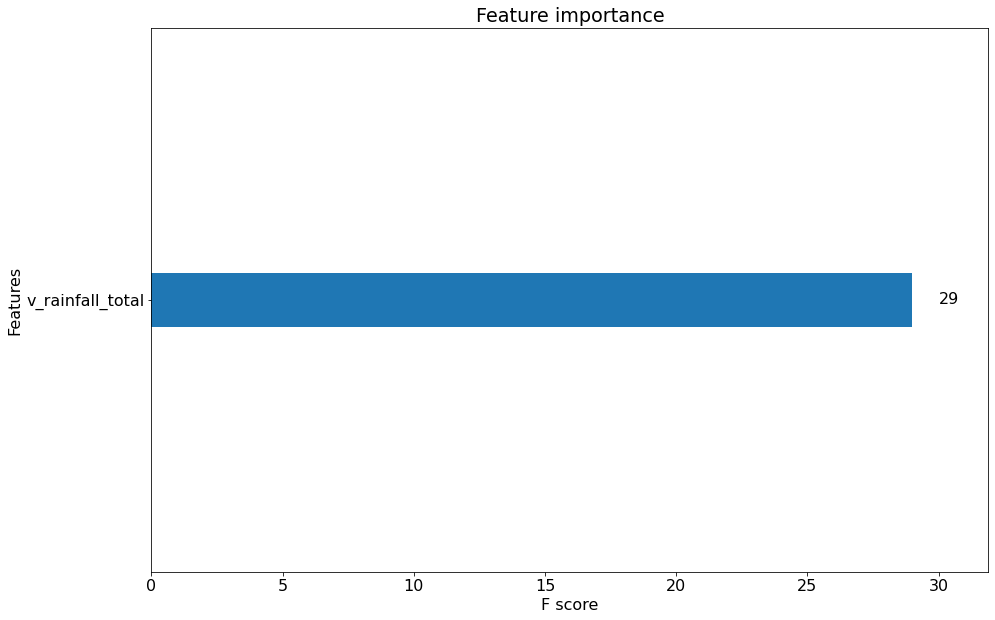

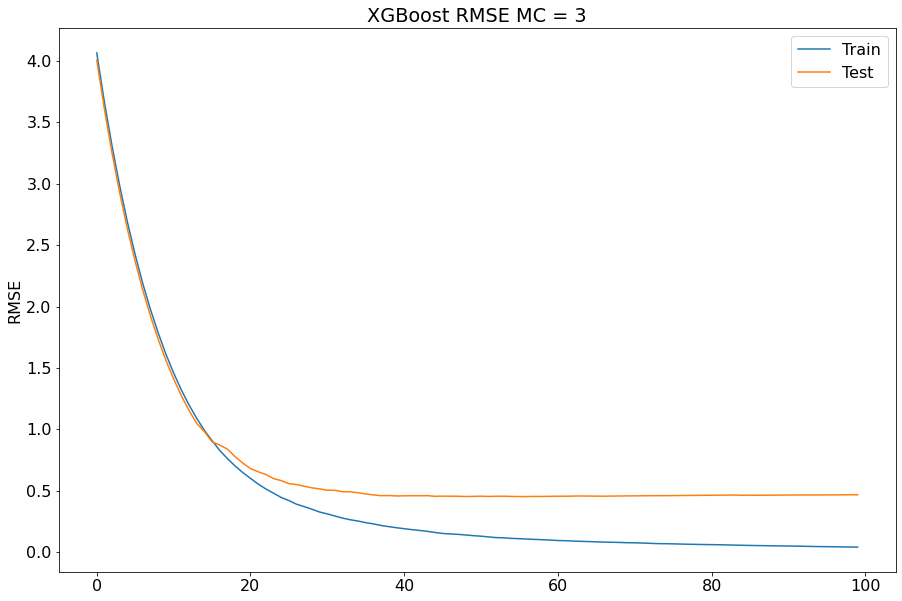

{'booster': 'gbtree', 'objective': 'reg:squarederror', 'subsample': 0.8, 'colsample_bytree': 0.85, 'eta': 0.05, 'max_depth': 16, 'gamma': 1, 'reg_alpha': 22, 'seed': 42}
First validation yelds RMSPE: 0.377448
[4.843037 4.843037 4.843037 4.843037 4.843037 4.843037 4.843037 4.843037
 4.843037 4.843037 4.843037 4.843037 4.843037 4.843037 4.843037 4.843037
 4.843037 4.843037 4.843037 4.843037 4.843037 4.843037 4.843037 4.843037]


ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.

In [15]:
# XGB with xgboost library (First simplified version with train and learn - Version 2)

params = {
    'booster': 'gbtree', 
    'objective': 'reg:squarederror', # regression task
    'subsample': 0.8, # 80% of data to grow trees and prevent overfitting
    'colsample_bytree': 1, # % of features used
    'eta': 0.08, 
    'max_depth': 10, 
    'seed': 42} # for reproducible results

forecast_steps = 24

XGB_metrics = pd.DataFrame()
XGB_prediction = pd.DataFrame()

for i in mcs:

    X_train = data_train[data_train['mc'] == i].copy()
    y_train = np.log(X_train.v_flow_mean[X_train['mc'] == i])
    X_test = data_test[data_test['mc'] == i].copy()
    y_test = np.log(X_test.v_flow_mean[data_test['mc'] == i])
    
    dtrain = xgb.DMatrix(X_train[predictors], y_train)
    dtest = xgb.DMatrix(X_test[predictors], y_test)

    watchlist = [(dtrain, 'train'), (dtest, 'test')]

    xgb_model = xgb.train(params, dtrain, 300, evals = watchlist, 
                          early_stopping_rounds = 50, feval = rmspe_xg, 
                          verbose_eval = False)
    
    params_sk = {
        'max_depth': 10, 
        'n_estimators': 100, # the same as num_rounds in xgboost
        'objective': 'reg:squarederror', 
        'subsample': 0.8, 
        'colsample_bytree': 0.85, 
        'learning_rate': 0.1, 
        'seed': 42}   
    
    skrg = XGBRegressor(**params_sk)

    skrg.fit(X_train[predictors], y_train, eval_set=[(X_train[predictors], y_train), 
                                                     (X_test[predictors], y_test)], 
            verbose = False)
    
    # retrieve performance metrics

    results = skrg.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    # plot AUC
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
    ax.legend()
    plt.ylabel('RMSE')
    plt.title('XGBoost RMSE MC = %s' % i)
    plt.show()
    
    # import scipy.stats as st
    params_grid = {  
        'learning_rate': [0.04, 0.05],
        'max_depth': [14,16],
        'gamma': [0.8,1],
        'reg_alpha': [22,23]
    }

    search_sk = RandomizedSearchCV(skrg, params_grid, cv = 2) # 5 fold cross validation
    search_sk.fit(X_train[predictors], y_train)

    # best parameters
#     print(search_sk.best_score_)
#     print(search_sk.best_params_)
    
    ls_best = search_sk.best_params_
    
    params_new = {
        'booster': 'gbtree', 
        'objective': 'reg:squarederror', 
        'subsample': 0.8, 
        'colsample_bytree': 0.85, 
        'eta': ls_best['learning_rate'], 
        'max_depth': ls_best['max_depth'], 
        'gamma': ls_best['gamma'],
        'reg_alpha': ls_best['reg_alpha'],
        'seed': 42
    } 
    
    print(params_new)

    model_final = xgb.train(params_new, dtrain, 100, evals = watchlist,
                            early_stopping_rounds = 50, feval = rmspe_xg, 
                            verbose_eval = False)
    
    yhat = model_final.predict(xgb.DMatrix(X_test[predictors]))
    error = rmspe(X_test.v_flow_mean.values, np.exp(yhat))

    print('First validation yelds RMSPE: {:.6f}'.format(error))
    print(yhat)
    
#     Model understanding
#     Feature importance scores help us see which variables contributed the 
#     most to the score.
    
    xgb.plot_importance(model_final)    
    
    # predictions to unseen data
    unseen = xgb.DMatrix(X_test[predictors])
    test_p = xgb_model.predict(unseen)
    
    temp_df = data_test[data_test['mc'] == i].copy()
    temp_df = temp_df[['v_flow_mean', 'v_loss_cover', 'v_rainfall_total']]
    temp_df.reset_index(drop=True, inplace=True)
    
    forecast = pd.DataFrame({'v_flow_mean_mean': np.exp(test_p)})
    forecast = pd.concat([dates, forecast, temp_df], axis = 1)
    forecast['mc'] = i
    
    print(forecast.head())
    
    forecast_errors = [temp_df.v_flow_mean.iloc[j] - forecast.v_flow_mean_mean.iloc[j] 
                       for j in range(forecast_steps)]
    bias = sum(forecast_errors) * 1.0 / (forecast_steps)
#     print('Bias : %f' % bias)

    mae = skm.mean_absolute_error(temp_df.v_flow_mean, forecast.v_flow_mean_mean)
#     print('MAE : %f' % mae)

    mse = skm.mean_squared_error(temp_df.v_flow_mean, forecast.v_flow_mean_mean)
    rmse = np.sqrt(mse)
#     print('MSE : %f' % mse)
#     print('RMSE : %f' % rmse) 
    
    resultados = [i, bias, mae, mse, rmse]
    resultados = pd.DataFrame([resultados], columns = ['mc', 'Bias', 'MAE', 'MSE', 'RMSE'])
    
    print(resultados.head())
    print('===========================================================\n')

    forecast = forecast[['date', 'year', 'month', 'mc', 'v_flow_mean_mean', 
                         'v_flow_mean', 'v_loss_cover', 'v_rainfall_total']]
    
    XGB_metrics = pd.concat([XGB_metrics, resultados], axis = 0)
    XGB_prediction = pd.concat([XGB_prediction, forecast], axis = 0)
    
    forecast['v_flow_mean_mean'].plot()    

# Guardar en archivos
    
XGB_metrics.to_csv('../model/XGB_results_v2.csv', index = False)
XGB_metrics.head()

XGB_prediction.to_csv('../model/XGB_predictions_v2.csv', index = False)
XGB_prediction.head()   
    